# **Load Library dan Data**

In [ ]:
!pip install pandas==1.5.3
!pip install numpy==1.24.3
!pip install scikit-learn==1.3.2
!pip install xgboost==1.7.6
!pip install catboost==1.2.2
!pip install lightgbm==4.1.0
!pip install joblib==1.3.2
!pip install matplotlib==3.7.2
!pip install seaborn==0.12.2
!pip install scipy==1.10.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import re
from scipy import stats

# Scikit-learn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    IsolationForest
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Gradient boosting libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Joblib untuk serialisasi (lebih efisien untuk model besar)
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

print("Loading additional libraries... ✓")

=== SMARTHOMEVALUATOR - FASE 2: FEATURE SELECTION & MODELING ===
Loading additional libraries... ✓


In [ ]:
def load_data(file_path):
    """Load dataset dan tampilkan info dasar"""
    try:
        df = pd.read_csv(file_path)
        print(f"\n📊 Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        return df
    except FileNotFoundError:
        print(f"❌ File {file_path} tidak ditemukan!")
        return None

# Load data (sesuaikan path file Anda)
df = load_data('rumah123_data.csv')

if df is not None:
    print("\n🔍 Sample data:")
    print(df.head(3))

    print("\n📋 Data Info:")
    print(df.info())

    print("\n❓ Missing Values:")
    print(df.isnull().sum())


📊 Dataset loaded successfully!
Shape: (10306, 12)
Columns: ['Harga', 'Judul', 'Lokasi', 'Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan', 'Carport', 'Daya Listrik', 'Jumlah Lantai', 'Kondisi Properti', 'Kondisi Perabotan']

🔍 Sample data:
            Harga                                              Judul  \
0   Rp 5,9 Miliar  Baru ! Dekat Rs Telogorejo Dan Simpanglima ! B...   
1  Rp 1,85 Miliar                  Rumah Area Tembalang Undip Dijual   
2     Rp 700 Juta  Owner Serius Di Jual Cepat Rumah Banyumanik Se...   

                      Lokasi  Kamar Tidur  Kamar Mandi Luas Tanah  \
0  Semarang Tengah, Semarang          3.0          2.0     414 m²   
1          Srondol, Semarang          3.0          2.0     199 m²   
2     Pudak Payung, Semarang          2.0          1.0      98 m²   

  Luas Bangunan  Carport Daya Listrik  Jumlah Lantai Kondisi Properti  \
0        250 m²      2.0    3500 Watt            1.0            Bagus   
1        185 m²      1.0    2200 Watt

# **Preprocessing**

**Harga**

In [ ]:
def parse_harga(harga_str):
    """
    Parse harga dari string ke numeric (Rupiah)
    Contoh: 'Rp 1,5 Miliar' -> 1500000000
    """
    if pd.isna(harga_str):
        return None

    # Clean string
    s = str(harga_str).strip()
    s = re.sub(r'(?i)Rp|IDR', '', s)  # Remove currency prefix
    s = re.sub(r'[^0-9,\.A-Za-z]', '', s)  # Keep only numbers, comma, dot, letters
    s = s.replace('.', '')  # Remove thousands separator

    # Extract number and unit (Miliar/Juta)
    match = re.match(r'([\d,]+)\s*(Miliar|Juta)?', s, flags=re.IGNORECASE)
    if not match:
        return None

    try:
        angka = float(match.group(1).replace(',', '.'))
        satuan = (match.group(2) or '').lower()

        if satuan == 'miliar':
            return angka * 1e9
        elif satuan == 'juta':
            return angka * 1e6
        else:
            return angka
    except:
        return None

def process_harga(df):
    """Process harga column dengan filtering outliers"""
    print("\n🏷️ PROCESSING HARGA...")

    # Parse harga
    df['Harga_num'] = df['Harga'].apply(parse_harga)

    # Info sebelum filtering
    print(f"Valid harga entries: {df['Harga_num'].notna().sum()}")
    print(f"Range harga: {df['Harga_num'].min():,.0f} - {df['Harga_num'].max():,.0f}")

    # Filter outliers (100 juta - 10 miliar)
    mask = (
        df['Harga_num'].notna() &
        (df['Harga_num'] > 0) &
        (df['Harga_num'] >= 100e6) &   # Min 100 juta
        (df['Harga_num'] <= 10e9)      # Max 10 miliar
    )

    df_filtered = df.loc[mask].copy()
    df_filtered['Harga_num'] = df_filtered['Harga_num'].astype('int64')

    # Create Harga_Miliar for easier interpretation
    df_filtered['Harga_Miliar'] = df_filtered['Harga_num'] / 1e9

    print(f"After filtering: {len(df_filtered)} rows ({len(df_filtered)/len(df)*100:.1f}%)")
    print(f"Filtered range: {df_filtered['Harga_num'].min():,.0f} - {df_filtered['Harga_num'].max():,.0f}")

    return df_filtered

# Process harga
df = process_harga(df)


🏷️ PROCESSING HARGA...
Valid harga entries: 10306
Range harga: 25,000,000 - 975,000,000,000
After filtering: 9627 rows (93.4%)
Filtered range: 123,000,000 - 10,000,000,000


**Lokasi**

In [ ]:
def create_zona_mapping():
    """Create mapping dari lokasi spesifik ke zona Semarang"""
    mapping = {
        # Semarang Barat
        "Semarang Barat": "Semarang Barat",
        "Kalibanteng": "Semarang Barat", "Kalibanteng Kulon": "Semarang Barat",
        "Kalibanteng kidul": "Semarang Barat", "Krapyak": "Semarang Barat",
        "Manyaran": "Semarang Barat", "Ngaliyan": "Semarang Barat",
        "Tugu": "Semarang Barat", "Tugurejo": "Semarang Barat",
        "Jerakah": "Semarang Barat", "Puspogiwang": "Semarang Barat",
        "Gajah Mungkur": "Semarang Barat", "Sampangan": "Semarang Barat",
        "Puspowarno": "Semarang Barat", "Puri Anjasmoro": "Semarang Barat",
        "Anjasmoro": "Semarang Barat", "Karangayu": "Semarang Barat",
        "Pusponjolo": "Semarang Barat", "Graha Padma": "Semarang Barat",
        "Kembang Arum": "Semarang Barat", "Tawangmas": "Semarang Barat",
        "Pamularsih": "Semarang Barat", "Mijen": "Semarang Barat",
        "Simongan": "Semarang Barat", "Bongsari": "Semarang Barat",
        "BSB City": "Semarang Barat",

        # Semarang Timur
        "Semarang Timur": "Semarang Timur",
        "Pedurungan": "Semarang Timur", "Tlogosari": "Semarang Timur",
        "Genuk": "Semarang Timur", "Gayamsari": "Semarang Timur",
        "Kedungmundu": "Semarang Timur", "Ketileng": "Semarang Timur",
        "Bangetayu": "Semarang Timur", "Bangetayu Wetan": "Semarang Timur",
        "Muktiharjo": "Semarang Timur", "Gemah": "Semarang Timur",
        "Plamongan": "Semarang Timur", "Meteseh": "Semarang Timur",
        "Mlatiharjo": "Semarang Timur", "Banyumanik": "Semarang Timur",
        "Tembalang": "Semarang Timur", "Bukit Sari": "Semarang Timur",
        "Sendangmulyo": "Semarang Timur", "Sambiroto": "Semarang Timur",
        "Srondol": "Semarang Timur", "Pudak Payung": "Semarang Timur",
        "Ngesrep": "Semarang Timur", "Jangli": "Semarang Timur",
        "Penggaron": "Semarang Timur", "Citragrand": "Semarang Timur",
        "Rejosari": "Semarang Timur", "Kalicari": "Semarang Timur",
        "Majapahit": "Semarang Timur", "Pedalangan": "Semarang Timur",
        "Kaligawe": "Semarang Timur",

        # Semarang Utara
        "Semarang Utara": "Semarang Utara",
        "Tanah Mas": "Semarang Utara", "Panggung": "Semarang Utara",
        "Kuningan": "Semarang Utara", "Plombokan": "Semarang Utara",
        "Tanjung Mas": "Semarang Utara", "Bandarharjo": "Semarang Utara",
        "Kampung Kali": "Semarang Utara",

        # Semarang Selatan
        "Semarang Selatan": "Semarang Selatan",
        "Wonodri": "Semarang Selatan", "Pleburan": "Semarang Selatan",
        "Candisari": "Semarang Selatan", "Jatingaleh": "Semarang Selatan",
        "Candi Golf": "Semarang Selatan", "Jomblang": "Semarang Selatan",
        "Lamper": "Semarang Selatan", "Karang Anyar": "Semarang Selatan",
        "Karang Rejo": "Semarang Selatan", "Karang Tempel": "Semarang Selatan",
        "Karang kidul": "Semarang Selatan", "Siranda": "Semarang Selatan",
        "Sompok": "Semarang Selatan", "Mugosari": "Semarang Selatan",
        "Tlaga Bodas": "Semarang Selatan", "Gajahmada": "Semarang Selatan",
        "Sultan Agung": "Semarang Selatan", "Peterongan": "Semarang Selatan",
        "Dr Cipto Mangunkusomo": "Semarang Selatan", "Atmodirono": "Semarang Selatan",
        "Bulustalan": "Semarang Selatan", "Pandansari": "Semarang Selatan",
        "Gajahmungkur": "Semarang Selatan", "Gunung Pati": "Semarang Selatan",
        "Barusari": "Semarang Selatan", "Pati Wetan": "Semarang Selatan",

        # Semarang Tengah
        "Semarang Tengah": "Semarang Tengah",
        "Simpang Lima": "Semarang Tengah", "Pemuda": "Semarang Tengah",
        "Sekayu": "Semarang Tengah", "Gabahan": "Semarang Tengah",
        "Kranggan": "Semarang Tengah", "Jagalan": "Semarang Tengah",
        "Miroto": "Semarang Tengah", "Pindrikan": "Semarang Tengah",
        "Pekunden": "Semarang Tengah", "Purwosari": "Semarang Tengah",
        "Pendirikan": "Semarang Tengah", "Brumbungan": "Semarang Tengah",
        "Mataram": "Semarang Tengah", "Kartini": "Semarang Tengah",
        "Bugangan": "Semarang Tengah", "Citarum": "Semarang Tengah",
        "Indraprasta": "Semarang Tengah", "Sidodadi Timur": "Semarang Tengah",
        "Kawi": "Semarang Tengah", "Halmahera": "Semarang Tengah",
        "Kaliwungu": "Semarang Tengah", "Krakatau": "Semarang Tengah",
        "Nias": "Semarang Tengah", "Semeru": "Semarang Tengah",
        "Sri Rejeki": "Semarang Tengah", "Kenconowungu": "Semarang Tengah",
        "Dempel": "Semarang Tengah", "Papandayan": "Semarang Tengah",
        "pekunden": "Semarang Tengah", "Cabean": "Semarang Tengah",
        "Gedung Batu": "Semarang Tengah", "Greenwood": "Semarang Tengah",
        "Karang Turi": "Semarang Tengah", "Kauman": "Semarang Tengah",
        "Purwodinatan": "Semarang Tengah", "Sarirejo": "Semarang Tengah",
        "papandayan": "Semarang Tengah"
    }

    # Lokasi luar kota Semarang (sekitar)
    luar_kota = [
        "Ungaran", "Ungaran Barat", "Ungaran Timur", "Bawen",
        "Bergas", "Boja", "Bandungan", "Mranggen", "Bringin",
        "Pringapus", "Sumowono", "Suruh", "Tengaran", "Tuntang",
        "Getasan", "Pabelan", "Banjardowo", "Kedung Pane",
        "Tengger", "Mangunsari"
    ]

    for lokasi in luar_kota:
        mapping[lokasi] = "Semarang Lainnya"

    return mapping

def map_lokasi_to_zona(lokasi, mapping):
    """Map lokasi ke zona dengan fuzzy matching"""
    if pd.isna(lokasi):
        return "Tidak Diketahui"

    # Clean lokasi string
    if isinstance(lokasi, str) and ", Semarang" in lokasi:
        lokasi = lokasi.replace(", Semarang", "").strip()

    # Direct mapping
    if lokasi in mapping:
        return mapping[lokasi]

    # Fuzzy matching
    for key, zona in mapping.items():
        if isinstance(key, str) and isinstance(lokasi, str):
            if key.lower() in lokasi.lower() or lokasi.lower() in key.lower():
                return zona

    return "Semarang Lainnya"

def process_lokasi(df):
    """Process lokasi column to zona with one-hot encoding"""
    print("\n🗺️ PROCESSING LOKASI TO ZONA...")

    mapping = create_zona_mapping()
    df['Zona'] = df['Lokasi'].apply(lambda x: map_lokasi_to_zona(x, mapping))

    print("Distribusi Zona:")
    zona_counts = df['Zona'].value_counts()
    for zona, count in zona_counts.items():
        print(f"  {zona}: {count} ({count/len(df)*100:.1f}%)")

    # One-hot encoding
    df = pd.get_dummies(df, columns=['Zona'], prefix='Zona')

    # Drop original Lokasi column
    df = df.drop(columns=['Lokasi'])

    return df

# Process lokasi
df = process_lokasi(df)


🗺️ PROCESSING LOKASI TO ZONA...
Distribusi Zona:
  Semarang Timur: 3883 (40.3%)
  Semarang Barat: 3312 (34.4%)
  Semarang Selatan: 972 (10.1%)
  Semarang Tengah: 698 (7.3%)
  Semarang Utara: 423 (4.4%)
  Semarang Lainnya: 339 (3.5%)


In [ ]:
def handle_missing_basic_features(df):
    """Handle missing values untuk fitur dasar"""
    print("\n🔧 HANDLING MISSING VALUES...")

    # Kamar Tidur & Kamar Mandi - imputasi dengan modus
    for col in ['Kamar Tidur', 'Kamar Mandi']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()

        if missing_before > 0:
            modus = df[col].mode()[0]
            df[col] = df[col].fillna(modus)
            print(f"  {col}: {missing_before} missing values filled with {modus}")

        df[col] = df[col].astype('int64')

    # Luas Tanah & Luas Bangunan - remove 'm²' dan imputasi dengan median
    for col in ['Luas Tanah', 'Luas Bangunan']:
        if col in df.columns:
            # Remove 'm²' suffix
            df[col] = df[col].astype(str).str.replace(' m²', '', regex=False).str.strip()
            df[col] = pd.to_numeric(df[col], errors='coerce')

            missing_before = df[col].isnull().sum()
            if missing_before > 0:
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                print(f"  {col}: {missing_before} missing values filled with median {median_val}")

            df[col] = df[col].astype('int64')

    # Carport - imputasi dengan modus
    if 'Carport' in df.columns:
        df['Carport'] = pd.to_numeric(df['Carport'], errors='coerce')
        missing_before = df['Carport'].isnull().sum()

        if missing_before > 0:
            modus = df['Carport'].mode()[0]
            df['Carport'] = df['Carport'].fillna(modus)
            print(f"  Carport: {missing_before} missing values filled with {modus}")

        df['Carport'] = df['Carport'].astype('int64')

    return df

def create_kategori_harga(df):
    """Create kategori harga berdasarkan harga properti"""
    def classify_harga(price):
        if price < 500e6:  # < 500 juta
            return 'Ekonomis'
        elif price < 1000e6:  # 500 juta - 1 miliar
            return 'Menengah Bawah'
        elif price < 2000e6:  # 1 - 2 miliar
            return 'Menengah'
        elif price < 3500e6:  # 2 - 3.5 miliar
            return 'Menengah Atas'
        elif price < 6000e6:  # 3.5 - 6 miliar
            return 'Premium'
        else:  # > 6 miliar
            return 'Luxury'

    df['Kategori_Harga'] = df['Harga_num'].apply(classify_harga)

    print("\n💰 KATEGORI HARGA:")
    kategori_counts = df['Kategori_Harga'].value_counts()
    for kategori, count in kategori_counts.items():
        avg_price = df[df['Kategori_Harga']==kategori]['Harga_Miliar'].mean()
        print(f"  {kategori}: {count} ({count/len(df)*100:.1f}%) - Avg: {avg_price:.2f}M")

    return df

def handle_daya_listrik(df):
    """Handle missing values untuk Daya Listrik berdasarkan kategori harga"""
    if 'Daya Listrik' not in df.columns:
        print("  Daya Listrik column not found, skipping...")
        return df

    # Remove 'Watt' suffix and convert to numeric
    df['Daya Listrik'] = df['Daya Listrik'].astype(str).str.replace(' Watt', '', regex=False)
    df['Daya Listrik'] = pd.to_numeric(df['Daya Listrik'], errors='coerce')

    missing_before = df['Daya Listrik'].isnull().sum()
    print(f"  Daya Listrik: {missing_before} missing values")

    if missing_before > 0:
        # Mapping kategori harga ke daya listrik (berdasarkan standar PLN)
        daya_mapping = {
            'Ekonomis': 900,        # 900 VA
            'Menengah Bawah': 1300, # 1300 VA
            'Menengah': 2200,       # 2200 VA
            'Menengah Atas': 3500,  # 3500 VA
            'Premium': 5500,        # 5500 VA
            'Luxury': 6600          # 6600 VA
        }

        # Imputasi berdasarkan kategori harga
        for kategori, daya in daya_mapping.items():
            mask = (df['Kategori_Harga'] == kategori) & (df['Daya Listrik'].isnull())
            df.loc[mask, 'Daya Listrik'] = daya

    df['Daya Listrik'] = df['Daya Listrik'].astype('int64')

    # Create kategori daya listrik
    def classify_daya(daya):
        if daya <= 450:
            return 'Dasar_450VA'
        elif daya <= 900:
            return 'Standar_900VA'
        elif daya <= 1300:
            return 'Menengah_1300VA'
        elif daya <= 2200:
            return 'Tinggi_2200VA'
        elif daya <= 3500:
            return 'Premium_3500VA'
        elif daya <= 5500:
            return 'Luxury_5500VA'
        else:
            return 'Ultra_5500VA_Plus'

    df['Kategori_Daya'] = df['Daya Listrik'].apply(classify_daya)

    print("  Distribusi Kategori Daya Listrik:")
    daya_counts = df['Kategori_Daya'].value_counts()
    for kategori, count in daya_counts.items():
        print(f"    {kategori}: {count}")

    # One-hot encoding
    df = pd.get_dummies(df, columns=['Kategori_Daya'], prefix='Daya')

    return df

def handle_jumlah_lantai(df):
    """Handle missing values untuk Jumlah Lantai"""
    if 'Jumlah Lantai' not in df.columns:
        print("  Jumlah Lantai column not found, skipping...")
        return df

    df['Jumlah Lantai'] = pd.to_numeric(df['Jumlah Lantai'], errors='coerce')
    missing_before = df['Jumlah Lantai'].isnull().sum()

    if missing_before > 0:
        # Imputasi berdasarkan kategori harga (group by category)
        def impute_lantai_by_category(group):
            if group['Jumlah Lantai'].isnull().any():
                modus = group['Jumlah Lantai'].mode()
                if len(modus) > 0:
                    group['Jumlah Lantai'] = group['Jumlah Lantai'].fillna(modus[0])
                else:
                    group['Jumlah Lantai'] = group['Jumlah Lantai'].fillna(1)  # default 1 lantai
            return group

        df = df.groupby('Kategori_Harga', group_keys=False).apply(impute_lantai_by_category)
        print(f"  Jumlah Lantai: {missing_before} missing values filled by category")

    df['Jumlah Lantai'] = df['Jumlah Lantai'].astype('int64')
    return df

def handle_categorical_features(df):
    """Handle missing values untuk fitur kategorikal dan one-hot encoding"""
    categorical_cols = ['Kondisi Properti', 'Kondisi Perabotan']

    for col in categorical_cols:
        if col in df.columns:
            # Clean and standardize
            df[col] = df[col].astype(str).str.strip().str.title()

            # Handle missing values with mode
            missing_before = df[col].isnull().sum()
            if missing_before > 0 or 'Nan' in df[col].values:
                modus = df[df[col] != 'Nan'][col].mode()[0] if len(df[df[col] != 'Nan']) > 0 else 'Unknown'
                df[col] = df[col].replace('Nan', modus)
                print(f"  {col}: filled with {modus}")

            # One-hot encoding
            df = pd.get_dummies(df, columns=[col], prefix=col.replace(' ', '_'))

    return df

# Process all missing values
df = handle_missing_basic_features(df)
df = create_kategori_harga(df)
df = handle_daya_listrik(df)
df = handle_jumlah_lantai(df)
df = handle_categorical_features(df)

# =====================================
# 6. FINAL DATA PREPARATION
# =====================================

def prepare_final_dataset(df):
    """Final preparation sebelum modeling"""
    print(f"\n📋 FINAL DATASET PREPARATION...")

    # Drop columns yang tidak diperlukan
    cols_to_drop = ['Harga', 'Judul', 'Kategori_Harga']  # Keep Harga_num and Harga_Miliar
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(columns=cols_to_drop)

    print(f"Shape after preprocessing: {df.shape}")
    print(f"Final columns: {len(df.columns)}")

    # Check for any remaining missing values
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        print("⚠️  Remaining missing values:")
        print(missing_summary[missing_summary > 0])
    else:
        print("✅ No missing values remaining!")

    # Show data types
    print(f"\nData types summary:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")

    return df

df = prepare_final_dataset(df)


🔧 HANDLING MISSING VALUES...
  Kamar Tidur: 294 missing values filled with 3.0
  Kamar Mandi: 285 missing values filled with 2.0
  Luas Tanah: 1 missing values filled with median 154.0
  Luas Bangunan: 20 missing values filled with median 140.0
  Carport: 3616 missing values filled with 1.0

💰 KATEGORI HARGA:
  Menengah: 2706 (28.1%) - Avg: 1.46M
  Menengah Bawah: 2225 (23.1%) - Avg: 0.75M
  Menengah Atas: 1786 (18.6%) - Avg: 2.59M
  Premium: 1315 (13.7%) - Avg: 4.40M
  Luxury: 807 (8.4%) - Avg: 7.65M
  Ekonomis: 788 (8.2%) - Avg: 0.39M
  Daya Listrik: 2742 missing values
  Distribusi Kategori Daya Listrik:
    Tinggi_2200VA: 3510
    Menengah_1300VA: 2364
    Premium_3500VA: 1409
    Luxury_5500VA: 1278
    Ultra_5500VA_Plus: 551
    Standar_900VA: 502
    Dasar_450VA: 13
  Jumlah Lantai: 1376 missing values filled by category
  Kondisi Properti: filled with Bagus
  Kondisi Perabotan: filled with Unfurnished

📋 FINAL DATASET PREPARATION...
Shape after preprocessing: (9627, 31)
Final 

# **EDA**

In [ ]:
# Set style untuk visualisasi yang lebih menarik
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [ ]:
def create_eda_overview(df):
    """Create overview statistik dataset"""
    print(f"\n📈 DATASET OVERVIEW:")
    print(f"Total Properties: {len(df):,}")
    print(f"Features: {df.shape[1]}")
    print(f"Price Range: Rp {df['Harga_num'].min():,.0f} - Rp {df['Harga_num'].max():,.0f}")
    print(f"Average Price: Rp {df['Harga_num'].mean():,.0f}")
    print(f"Median Price: Rp {df['Harga_num'].median():,.0f}")

    # Statistik deskriptif untuk fitur numerik utama
    numeric_features = ['Harga_Miliar', 'Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan', 'Carport', 'Jumlah Lantai']
    numeric_features = [col for col in numeric_features if col in df.columns]

    print(f"\n📊 DESCRIPTIVE STATISTICS:")
    print(df[numeric_features].describe().round(2))

In [ ]:
def plot_harga_distribution(df):
    """Visualisasi distribusi harga"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🏠 DISTRIBUSI HARGA PROPERTI SEMARANG', fontsize=16, fontweight='bold', y=0.98)

    # 1. Histogram Harga (Miliar)
    axes[0,0].hist(df['Harga_Miliar'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Histogram Harga (Miliar Rupiah)', fontweight='bold')
    axes[0,0].set_xlabel('Harga (Miliar Rp)')
    axes[0,0].set_ylabel('Frekuensi')
    axes[0,0].axvline(df['Harga_Miliar'].mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: {df["Harga_Miliar"].mean():.2f}M')
    axes[0,0].axvline(df['Harga_Miliar'].median(), color='green', linestyle='--', alpha=0.8, label=f'Median: {df["Harga_Miliar"].median():.2f}M')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Box Plot Harga
    box_plot = axes[0,1].boxplot(df['Harga_Miliar'], patch_artist=True, notch=True)
    box_plot['boxes'][0].set_facecolor('lightcoral')
    axes[0,1].set_title('Box Plot Harga (Miliar Rupiah)', fontweight='bold')
    axes[0,1].set_ylabel('Harga (Miliar Rp)')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Log-Normal Distribution Check
    log_harga = np.log(df['Harga_Miliar'])
    axes[1,0].hist(log_harga, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_title('Log-Transformed Harga Distribution', fontweight='bold')
    axes[1,0].set_xlabel('Log(Harga Miliar)')
    axes[1,0].set_ylabel('Frekuensi')
    axes[1,0].grid(True, alpha=0.3)

    # 4. Q-Q Plot untuk normalitas
    stats.probplot(df['Harga_Miliar'], dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot: Normalitas Harga', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Skewness dan Kurtosis
    skewness = df['Harga_Miliar'].skew()
    kurtosis = df['Harga_Miliar'].kurtosis()
    print(f"\n📐 DISTRIBUSI STATISTICS:")
    print(f"Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0 else 'Left-skewed'})")
    print(f"Kurtosis: {kurtosis:.3f} ({'Heavy-tailed' if kurtosis > 0 else 'Light-tailed'})")

In [ ]:
def plot_zona_analysis(df):
    """Analisis harga berdasarkan zona"""
    # Identifikasi kolom zona
    zona_cols = [col for col in df.columns if col.startswith('Zona_')]

    if not zona_cols:
        print("⚠️ No zona columns found for analysis")
        return

    # Rekonstruksi zona dari one-hot encoding
    df_zona = df.copy()
    zona_data = []

    for idx, row in df_zona.iterrows():
        for zona_col in zona_cols:
            if row[zona_col] == 1:
                zona_name = zona_col.replace('Zona_', '')
                zona_data.append({
                    'Harga_Miliar': row['Harga_Miliar'],
                    'Harga_num': row['Harga_num'],
                    'Zona': zona_name
                })
                break

    zona_df = pd.DataFrame(zona_data)

    if zona_df.empty:
        print("⚠️ No zona data found")
        return

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🗺️ ANALISIS HARGA BERDASARKAN ZONA SEMARANG', fontsize=16, fontweight='bold', y=0.98)

    # 1. Bar Plot - Average Price by Zona
    zona_avg = zona_df.groupby('Zona')['Harga_Miliar'].agg(['mean', 'count']).sort_values('mean', ascending=False)

    bars = axes[0,0].bar(range(len(zona_avg)), zona_avg['mean'], color='lightblue', edgecolor='navy', alpha=0.8)
    axes[0,0].set_title('Rata-rata Harga per Zona', fontweight='bold')
    axes[0,0].set_xlabel('Zona')
    axes[0,0].set_ylabel('Rata-rata Harga (Miliar Rp)')
    axes[0,0].set_xticks(range(len(zona_avg)))
    axes[0,0].set_xticklabels(zona_avg.index, rotation=45, ha='right')
    axes[0,0].grid(True, alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                      f'{height:.2f}M\n({zona_avg.iloc[i]["count"]} units)',
                      ha='center', va='bottom', fontsize=8)

    # 2. Box Plot - Price Distribution by Zona
    zona_order = zona_avg.index.tolist()
    sns.boxplot(data=zona_df, x='Zona', y='Harga_Miliar', order=zona_order, ax=axes[0,1])
    axes[0,1].set_title('Distribusi Harga per Zona', fontweight='bold')
    axes[0,1].set_xlabel('Zona')
    axes[0,1].set_ylabel('Harga (Miliar Rp)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # 3. Count Plot - Jumlah Properties per Zona
    zona_counts = zona_df['Zona'].value_counts()
    bars2 = axes[1,0].bar(zona_counts.index, zona_counts.values, color='lightcoral', edgecolor='darkred', alpha=0.8)
    axes[1,0].set_title('Jumlah Properti per Zona', fontweight='bold')
    axes[1,0].set_xlabel('Zona')
    axes[1,0].set_ylabel('Jumlah Properti')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)

    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # 4. Pie Chart - Market Share by Zona
    axes[1,1].pie(zona_counts.values, labels=zona_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Market Share per Zona', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print zona statistics
    print(f"\n🏘️ ZONA STATISTICS:")
    for zona in zona_order:
        zona_data_subset = zona_df[zona_df['Zona'] == zona]
        print(f"  {zona}:")
        print(f"    Count: {len(zona_data_subset)} properties")
        print(f"    Average: Rp {zona_data_subset['Harga_Miliar'].mean():.2f}M")
        print(f"    Median: Rp {zona_data_subset['Harga_Miliar'].median():.2f}M")
        print(f"    Range: Rp {zona_data_subset['Harga_Miliar'].min():.2f}M - Rp {zona_data_subset['Harga_Miliar'].max():.2f}M")

In [ ]:
def plot_features_analysis(df):
    """Analisis fitur-fitur properti"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🏡 ANALISIS FITUR PROPERTI', fontsize=16, fontweight='bold', y=0.98)

    # 1. Kamar Tidur vs Harga
    kamar_tidur_avg = df.groupby('Kamar Tidur')['Harga_Miliar'].agg(['mean', 'count'])
    bars1 = axes[0,0].bar(kamar_tidur_avg.index, kamar_tidur_avg['mean'], color='skyblue', edgecolor='navy', alpha=0.8)
    axes[0,0].set_title('Rata-rata Harga vs Kamar Tidur', fontweight='bold')
    axes[0,0].set_xlabel('Jumlah Kamar Tidur')
    axes[0,0].set_ylabel('Rata-rata Harga (Miliar Rp)')
    axes[0,0].grid(True, alpha=0.3)

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        count = kamar_tidur_avg.iloc[i]['count']
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                      f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    # 2. Kamar Mandi vs Harga
    kamar_mandi_avg = df.groupby('Kamar Mandi')['Harga_Miliar'].agg(['mean', 'count'])
    bars2 = axes[0,1].bar(kamar_mandi_avg.index, kamar_mandi_avg['mean'], color='lightcoral', edgecolor='darkred', alpha=0.8)
    axes[0,1].set_title('Rata-rata Harga vs Kamar Mandi', fontweight='bold')
    axes[0,1].set_xlabel('Jumlah Kamar Mandi')
    axes[0,1].set_ylabel('Rata-rata Harga (Miliar Rp)')
    axes[0,1].grid(True, alpha=0.3)

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        count = kamar_mandi_avg.iloc[i]['count']
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                      f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    # 3. Jumlah Lantai vs Harga
    if 'Jumlah Lantai' in df.columns:
        lantai_avg = df.groupby('Jumlah Lantai')['Harga_Miliar'].agg(['mean', 'count'])
        bars3 = axes[0,2].bar(lantai_avg.index, lantai_avg['mean'], color='lightgreen', edgecolor='darkgreen', alpha=0.8)
        axes[0,2].set_title('Rata-rata Harga vs Jumlah Lantai', fontweight='bold')
        axes[0,2].set_xlabel('Jumlah Lantai')
        axes[0,2].set_ylabel('Rata-rata Harga (Miliar Rp)')
        axes[0,2].grid(True, alpha=0.3)

        for i, bar in enumerate(bars3):
            height = bar.get_height()
            count = lantai_avg.iloc[i]['count']
            axes[0,2].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                          f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    # 4. Scatter Plot: Luas Tanah vs Harga
    axes[1,0].scatter(df['Luas Tanah'], df['Harga_Miliar'], alpha=0.6, color='orange')
    axes[1,0].set_title('Luas Tanah vs Harga', fontweight='bold')
    axes[1,0].set_xlabel('Luas Tanah (m²)')
    axes[1,0].set_ylabel('Harga (Miliar Rp)')
    axes[1,0].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_tanah = df['Luas Tanah'].corr(df['Harga_Miliar'])
    axes[1,0].text(0.05, 0.95, f'Correlation: {corr_tanah:.3f}', transform=axes[1,0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 5. Scatter Plot: Luas Bangunan vs Harga
    axes[1,1].scatter(df['Luas Bangunan'], df['Harga_Miliar'], alpha=0.6, color='purple')
    axes[1,1].set_title('Luas Bangunan vs Harga', fontweight='bold')
    axes[1,1].set_xlabel('Luas Bangunan (m²)')
    axes[1,1].set_ylabel('Harga (Miliar Rp)')
    axes[1,1].grid(True, alpha=0.3)

    # Add correlation coefficient
    corr_bangunan = df['Luas Bangunan'].corr(df['Harga_Miliar'])
    axes[1,1].text(0.05, 0.95, f'Correlation: {corr_bangunan:.3f}', transform=axes[1,1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 6. Carport vs Harga
    if 'Carport' in df.columns:
        carport_avg = df.groupby('Carport')['Harga_Miliar'].agg(['mean', 'count'])
        bars4 = axes[1,2].bar(carport_avg.index, carport_avg['mean'], color='gold', edgecolor='orange', alpha=0.8)
        axes[1,2].set_title('Rata-rata Harga vs Carport', fontweight='bold')
        axes[1,2].set_xlabel('Jumlah Carport')
        axes[1,2].set_ylabel('Rata-rata Harga (Miliar Rp)')
        axes[1,2].grid(True, alpha=0.3)

        for i, bar in enumerate(bars4):
            height = bar.get_height()
            count = carport_avg.iloc[i]['count']
            axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                          f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_categorical_analysis(df):
    """Analisis fitur kategorikal"""
    # Identifikasi kolom kategorikal
    kondisi_properti_cols = [col for col in df.columns if col.startswith('Kondisi_Properti_')]
    kondisi_perabotan_cols = [col for col in df.columns if col.startswith('Kondisi_Perabotan_')]
    daya_cols = [col for col in df.columns if col.startswith('Daya_')]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🏠 ANALISIS FITUR KATEGORIKAL', fontsize=16, fontweight='bold', y=0.98)

    # 1. Kondisi Properti Analysis
    if kondisi_properti_cols:
        kondisi_data = []
        for idx, row in df.iterrows():
            for col in kondisi_properti_cols:
                if row[col] == 1:
                    kondisi_name = col.replace('Kondisi_Properti_', '')
                    kondisi_data.append({
                        'Harga_Miliar': row['Harga_Miliar'],
                        'Kondisi': kondisi_name
                    })
                    break

        if kondisi_data:
            kondisi_df = pd.DataFrame(kondisi_data)
            kondisi_avg = kondisi_df.groupby('Kondisi')['Harga_Miliar'].agg(['mean', 'count']).sort_values('mean', ascending=False)

            bars1 = axes[0,0].bar(range(len(kondisi_avg)), kondisi_avg['mean'], color='lightblue', edgecolor='navy', alpha=0.8)
            axes[0,0].set_title('Rata-rata Harga vs Kondisi Properti', fontweight='bold')
            axes[0,0].set_xlabel('Kondisi Properti')
            axes[0,0].set_ylabel('Rata-rata Harga (Miliar Rp)')
            axes[0,0].set_xticks(range(len(kondisi_avg)))
            axes[0,0].set_xticklabels(kondisi_avg.index, rotation=45, ha='right')
            axes[0,0].grid(True, alpha=0.3)

            for i, bar in enumerate(bars1):
                height = bar.get_height()
                count = kondisi_avg.iloc[i]['count']
                axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                              f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    # 2. Kondisi Perabotan Analysis
    if kondisi_perabotan_cols:
        perabotan_data = []
        for idx, row in df.iterrows():
            for col in kondisi_perabotan_cols:
                if row[col] == 1:
                    perabotan_name = col.replace('Kondisi_Perabotan_', '')
                    perabotan_data.append({
                        'Harga_Miliar': row['Harga_Miliar'],
                        'Perabotan': perabotan_name
                    })
                    break

        if perabotan_data:
            perabotan_df = pd.DataFrame(perabotan_data)
            perabotan_avg = perabotan_df.groupby('Perabotan')['Harga_Miliar'].agg(['mean', 'count']).sort_values('mean', ascending=False)

            bars2 = axes[0,1].bar(range(len(perabotan_avg)), perabotan_avg['mean'], color='lightcoral', edgecolor='darkred', alpha=0.8)
            axes[0,1].set_title('Rata-rata Harga vs Kondisi Perabotan', fontweight='bold')
            axes[0,1].set_xlabel('Kondisi Perabotan')
            axes[0,1].set_ylabel('Rata-rata Harga (Miliar Rp)')
            axes[0,1].set_xticks(range(len(perabotan_avg)))
            axes[0,1].set_xticklabels(perabotan_avg.index, rotation=45, ha='right')
            axes[0,1].grid(True, alpha=0.3)

            for i, bar in enumerate(bars2):
                height = bar.get_height()
                count = perabotan_avg.iloc[i]['count']
                axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                              f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    # 3. Daya Listrik Analysis
    if daya_cols:
        daya_data = []
        for idx, row in df.iterrows():
            for col in daya_cols:
                if row[col] == 1:
                    daya_name = col.replace('Daya_', '')
                    daya_data.append({
                        'Harga_Miliar': row['Harga_Miliar'],
                        'Daya': daya_name
                    })
                    break

        if daya_data:
            daya_df = pd.DataFrame(daya_data)
            daya_avg = daya_df.groupby('Daya')['Harga_Miliar'].agg(['mean', 'count']).sort_values('mean', ascending=False)

            bars3 = axes[1,0].bar(range(len(daya_avg)), daya_avg['mean'], color='lightgreen', edgecolor='darkgreen', alpha=0.8)
            axes[1,0].set_title('Rata-rata Harga vs Kategori Daya Listrik', fontweight='bold')
            axes[1,0].set_xlabel('Kategori Daya Listrik')
            axes[1,0].set_ylabel('Rata-rata Harga (Miliar Rp)')
            axes[1,0].set_xticks(range(len(daya_avg)))
            axes[1,0].set_xticklabels(daya_avg.index, rotation=45, ha='right')
            axes[1,0].grid(True, alpha=0.3)

            for i, bar in enumerate(bars3):
                height = bar.get_height()
                count = daya_avg.iloc[i]['count']
                axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                              f'{height:.2f}M\n({count} units)', ha='center', va='bottom', fontsize=8)

    # 4. Combined Analysis - Price Range Distribution
    price_ranges = pd.cut(df['Harga_Miliar'], bins=[0, 0.5, 1, 2, 3.5, 6, float('inf')],
                         labels=['<500 Juta', '500 Juta-1M', '1-2M', '2-3.5M', '3.5-6M', '>6M'])
    range_counts = price_ranges.value_counts()

    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF']
    axes[1,1].pie(range_counts.values, labels=range_counts.index, autopct='%1.1f%%',
                  colors=colors, startangle=90)
    axes[1,1].set_title('Distribusi Rentang Harga', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def create_correlation_matrix(df):
    """Create correlation matrix untuk fitur numerik"""
    # Pilih fitur numerik
    numeric_features = ['Harga_Miliar', 'Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan']
    if 'Carport' in df.columns:
        numeric_features.append('Carport')
    if 'Jumlah Lantai' in df.columns:
        numeric_features.append('Jumlah Lantai')
    if 'Daya Listrik' in df.columns:
        numeric_features.append('Daya Listrik')

    # Filter kolom yang ada
    available_features = [col for col in numeric_features if col in df.columns]

    if len(available_features) < 2:
        print("⚠️ Not enough numeric features for correlation analysis")
        return

    # Calculate correlation matrix
    corr_matrix = df[available_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f')

    plt.title('🔗 CORRELATION MATRIX - FITUR NUMERIK', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Print strong correlations with price
    print(f"\n🔗 KORELASI DENGAN HARGA:")
    price_corr = corr_matrix['Harga_Miliar'].drop('Harga_Miliar').sort_values(key=abs, ascending=False)
    for feature, corr_val in price_corr.items():
        strength = "Very Strong" if abs(corr_val) >= 0.8 else "Strong" if abs(corr_val) >= 0.6 else "Moderate" if abs(corr_val) >= 0.4 else "Weak"
        direction = "Positive" if corr_val > 0 else "Negative"
        print(f"  {feature}: {corr_val:.3f} ({strength} {direction})")

In [ ]:
def generate_insights(df):
    """Generate business insights dari EDA"""
    print(f"\n" + "="*60)
    print(f"📊 BUSINESS INSIGHTS - SMARTHOMEVALUATOR")
    print(f"="*60)

    # 1. Market Overview
    total_properties = len(df)
    avg_price = df['Harga_Miliar'].mean()
    median_price = df['Harga_Miliar'].median()

    print(f"\n🏠 MARKET OVERVIEW:")
    print(f"  • Total Properties Analyzed: {total_properties:,}")
    print(f"  • Average Price: Rp {avg_price:.2f} Miliar")
    print(f"  • Median Price: Rp {median_price:.2f} Miliar")
    print(f"  • Price Premium (Avg/Median): {(avg_price/median_price-1)*100:.1f}%")

    # 2. Most Common Configuration
    mode_kt = df['Kamar Tidur'].mode()[0]
    mode_km = df['Kamar Mandi'].mode()[0]
    mode_luas_tanah = df['Luas Tanah'].median()
    mode_luas_bangunan = df['Luas Bangunan'].median()

    print(f"\n🏡 TYPICAL PROPERTY PROFILE:")
    print(f"  • Most Common: {mode_kt} bedrooms, {mode_km} bathrooms")
    print(f"  • Median Land Area: {mode_luas_tanah:.0f} m²")
    print(f"  • Median Building Area: {mode_luas_bangunan:.0f} m²")

    # 3. Premium Features Impact
    if 'Luas Bangunan' in df.columns and 'Luas Tanah' in df.columns:
        large_building = df[df['Luas Bangunan'] > df['Luas Bangunan'].quantile(0.75)]
        large_land = df[df['Luas Tanah'] > df['Luas Tanah'].quantile(0.75)]

        premium_building_price = large_building['Harga_Miliar'].mean()
        premium_land_price = large_land['Harga_Miliar'].mean()

        print(f"\n💎 PREMIUM FEATURES IMPACT:")
        print(f"  • Large Buildings (>Q3): +{((premium_building_price/avg_price-1)*100):.1f}% price premium")
        print(f"  • Large Land (>Q3): +{((premium_land_price/avg_price-1)*100):.1f}% price premium")

    # 4. Zona Analysis
    zona_cols = [col for col in df.columns if col.startswith('Zona_')]
    if zona_cols:
        zona_data = []
        for idx, row in df.iterrows():
            for zona_col in zona_cols:
                if row[zona_col] == 1:
                    zona_name = zona_col.replace('Zona_', '')
                    zona_data.append({
                        'Harga_Miliar': row['Harga_Miliar'],
                        'Zona': zona_name
                    })
                    break

        if zona_data:
            zona_df = pd.DataFrame(zona_data)
            zona_avg = zona_df.groupby('Zona')['Harga_Miliar'].agg(['mean', 'count']).sort_values('mean', ascending=False)

            print(f"\n🗺️ ZONA PREMIUM RANKING:")
            for i, (zona, data) in enumerate(zona_avg.head(3).iterrows()):
                print(f"  {i+1}. {zona}: Rp {data['mean']:.2f}M avg ({data['count']} properties)")

            # Market concentration
            total_properties_zona = zona_df.shape[0]
            top_zona_share = zona_avg.head(3)['count'].sum() / total_properties_zona * 100
            print(f"  • Top 3 zones control {top_zona_share:.1f}% of the market")

    # 5. Investment Recommendations
    print(f"\n💰 INVESTMENT INSIGHTS:")

    # Price per sqm analysis
    if 'Luas Bangunan' in df.columns:
        df['Price_per_sqm'] = df['Harga_num'] / df['Luas Bangunan']
        affordable_psm = df['Price_per_sqm'].quantile(0.25)
        expensive_psm = df['Price_per_sqm'].quantile(0.75)

        print(f"  • Price per m² range: Rp {affordable_psm:,.0f} - Rp {expensive_psm:,.0f}")

        # Value opportunities
        value_properties = df[
            (df['Price_per_sqm'] < df['Price_per_sqm'].median()) &
            (df['Luas Bangunan'] > df['Luas Bangunan'].median())
        ]
        print(f"  • Value opportunities: {len(value_properties)} large properties with below-median price/m²")

    # 6. Market Segmentation
    print(f"\n📈 MARKET SEGMENTATION:")

    # Define price segments
    price_segments = pd.cut(df['Harga_Miliar'],
                           bins=[0, 1, 2, 3.5, float('inf')],
                           labels=['Budget (<1M)', 'Mid-range (1-2M)', 'Premium (2-3.5M)', 'Luxury (>3.5M)'])

    segment_counts = price_segments.value_counts()
    for segment, count in segment_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  • {segment}: {count} properties ({percentage:.1f}%)")

    # 7. Feature Importance Rankings
    print(f"\n🔑 KEY VALUE DRIVERS:")

    # Correlation with price
    numeric_features = ['Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan']
    if 'Carport' in df.columns:
        numeric_features.append('Carport')
    if 'Jumlah Lantai' in df.columns:
        numeric_features.append('Jumlah Lantai')

    available_features = [col for col in numeric_features if col in df.columns]

    if available_features:
        correlations = df[available_features + ['Harga_Miliar']].corr()['Harga_Miliar'].drop('Harga_Miliar')
        top_correlations = correlations.abs().sort_values(ascending=False)

        for i, (feature, corr) in enumerate(top_correlations.head(5).items()):
            print(f"  {i+1}. {feature}: {corr:.3f} correlation")

    # 8. Market Trends & Opportunities
    print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
    print(f"  • Focus on properties with 3-4 bedrooms (most common segment)")
    print(f"  • Large building area shows strongest correlation with price")
    print(f"  • Consider undervalued properties in emerging zones")

    if 'Luas Bangunan' in df.columns and 'Luas Tanah' in df.columns:
        efficiency_ratio = (df['Luas Bangunan'] / df['Luas Tanah']).median()
        print(f"  • Optimal building-to-land ratio: {efficiency_ratio:.2f}")

    print(f"\n" + "="*60)
    print(f"✅ EDA ANALYSIS COMPLETED SUCCESSFULLY!")
    print(f"="*60)

In [ ]:
def run_complete_eda(df):
    """Menjalankan seluruh proses EDA"""
    print("🚀 Starting Complete EDA Process...")

    # 1. Dataset Overview
    create_eda_overview(df)

    # 2. Price Distribution Analysis
    print("\n📊 Analyzing price distributions...")
    plot_harga_distribution(df)

    # 3. Zona Analysis
    print("\n🗺️ Analyzing zona patterns...")
    plot_zona_analysis(df)

    # 4. Features Analysis
    print("\n🏡 Analyzing property features...")
    plot_features_analysis(df)

    # 5. Categorical Features Analysis
    print("\n📋 Analyzing categorical features...")
    plot_categorical_analysis(df)

    # 6. Correlation Analysis
    print("\n🔗 Creating correlation matrix...")
    create_correlation_matrix(df)

    # 7. Business Insights
    print("\n💡 Generating business insights...")
    generate_insights(df)

    return True

In [ ]:
def main():
    """Main function untuk menjalankan EDA"""
    print("=== SMARTHOMEVALUATOR EDA INITIALIZATION ===")
    print("Please ensure your dataset is loaded as 'df' variable")
    print("Then call: run_complete_eda(df)")
    print("\nRequired columns:")
    print("- Harga_num, Harga_Miliar")
    print("- Kamar Tidur, Kamar Mandi")
    print("- Luas Tanah, Luas Bangunan")
    print("- Zona_* (one-hot encoded)")
    print("- Kondisi_Properti_*, Kondisi_Perabotan_*, Daya_* (optional)")
    print("\nExample usage:")
    print(">>> df = pd.read_csv('your_dataset.csv')")
    print(">>> success = run_complete_eda(df)")

if __name__ == "__main__":
    main()

=== SMARTHOMEVALUATOR EDA INITIALIZATION ===
Please ensure your dataset is loaded as 'df' variable
Then call: run_complete_eda(df)

Required columns:
- Harga_num, Harga_Miliar
- Kamar Tidur, Kamar Mandi
- Luas Tanah, Luas Bangunan
- Zona_* (one-hot encoded)
- Kondisi_Properti_*, Kondisi_Perabotan_*, Daya_* (optional)

Example usage:
>>> df = pd.read_csv('your_dataset.csv')
>>> success = run_complete_eda(df)


In [ ]:
def quick_price_summary(df):
    """Quick price summary untuk debugging"""
    print(f"Price Summary:")
    print(f"Min: Rp {df['Harga_Miliar'].min():.2f}M")
    print(f"Max: Rp {df['Harga_Miliar'].max():.2f}M")
    print(f"Mean: Rp {df['Harga_Miliar'].mean():.2f}M")
    print(f"Median: Rp {df['Harga_Miliar'].median():.2f}M")

def check_data_quality(df):
    """Check data quality issues"""
    print("Data Quality Check:")
    print(f"Total rows: {len(df)}")
    print(f"Missing values:")
    missing = df.isnull().sum()
    for col, miss_count in missing[missing > 0].items():
        print(f"  {col}: {miss_count} ({miss_count/len(df)*100:.1f}%)")

    print(f"Duplicate rows: {df.duplicated().sum()}")

    # Check for outliers in price
    Q1 = df['Harga_Miliar'].quantile(0.25)
    Q3 = df['Harga_Miliar'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['Harga_Miliar'] < Q1 - 1.5*IQR) | (df['Harga_Miliar'] > Q3 + 1.5*IQR)]
    print(f"Price outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

In [ ]:
def export_eda_report(df, filename='eda_report.txt'):
    """Export EDA insights to text file"""
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("SMARTHOMEVALUATOR - EDA REPORT\n")
        f.write("="*50 + "\n\n")

        # Basic stats
        f.write(f"Dataset Overview:\n")
        f.write(f"Total Properties: {len(df):,}\n")
        f.write(f"Features: {df.shape[1]}\n")
        f.write(f"Price Range: Rp {df['Harga_num'].min():,.0f} - Rp {df['Harga_num'].max():,.0f}\n")
        f.write(f"Average Price: Rp {df['Harga_num'].mean():,.0f}\n")
        f.write(f"Median Price: Rp {df['Harga_num'].median():,.0f}\n\n")

        # Feature correlations
        numeric_features = ['Harga_Miliar', 'Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan']
        available_features = [col for col in numeric_features if col in df.columns]

        if len(available_features) > 1:
            corr_matrix = df[available_features].corr()
            f.write("Correlation with Price:\n")
            price_corr = corr_matrix['Harga_Miliar'].drop('Harga_Miliar').sort_values(key=abs, ascending=False)
            for feature, corr_val in price_corr.items():
                f.write(f"  {feature}: {corr_val:.3f}\n")

    print(f"EDA report exported to {filename}")

print("📊 SmartHomeValuator EDA Module Loaded Successfully!")
print("Ready to analyze Semarang property data 🏠")

📊 SmartHomeValuator EDA Module Loaded Successfully!
Ready to analyze Semarang property data 🏠


🚀 Starting Complete EDA Process...

📈 DATASET OVERVIEW:
Total Properties: 9,627
Features: 31
Price Range: Rp 123,000,000 - Rp 10,000,000,000
Average Price: Rp 2,337,953,153
Median Price: Rp 1,600,000,000

📊 DESCRIPTIVE STATISTICS:
       Harga_Miliar  Kamar Tidur  Kamar Mandi  Luas Tanah  Luas Bangunan  \
count       9627.00      9627.00      9627.00     9627.00        9627.00   
mean           2.34         3.76         2.58      210.31         184.93   
std            2.08         3.28         2.83      209.45         181.36   
min            0.12         1.00         1.00        1.00           1.00   
25%            0.85         2.00         1.00      112.00          80.00   
50%            1.60         3.00         2.00      154.00         140.00   
75%            3.00         4.00         3.00      244.00         240.00   
max           10.00        68.00        68.00     9600.00        7000.00   

       Carport  Jumlah Lantai  
count  9627.00        9627.00  
mean      1.37      

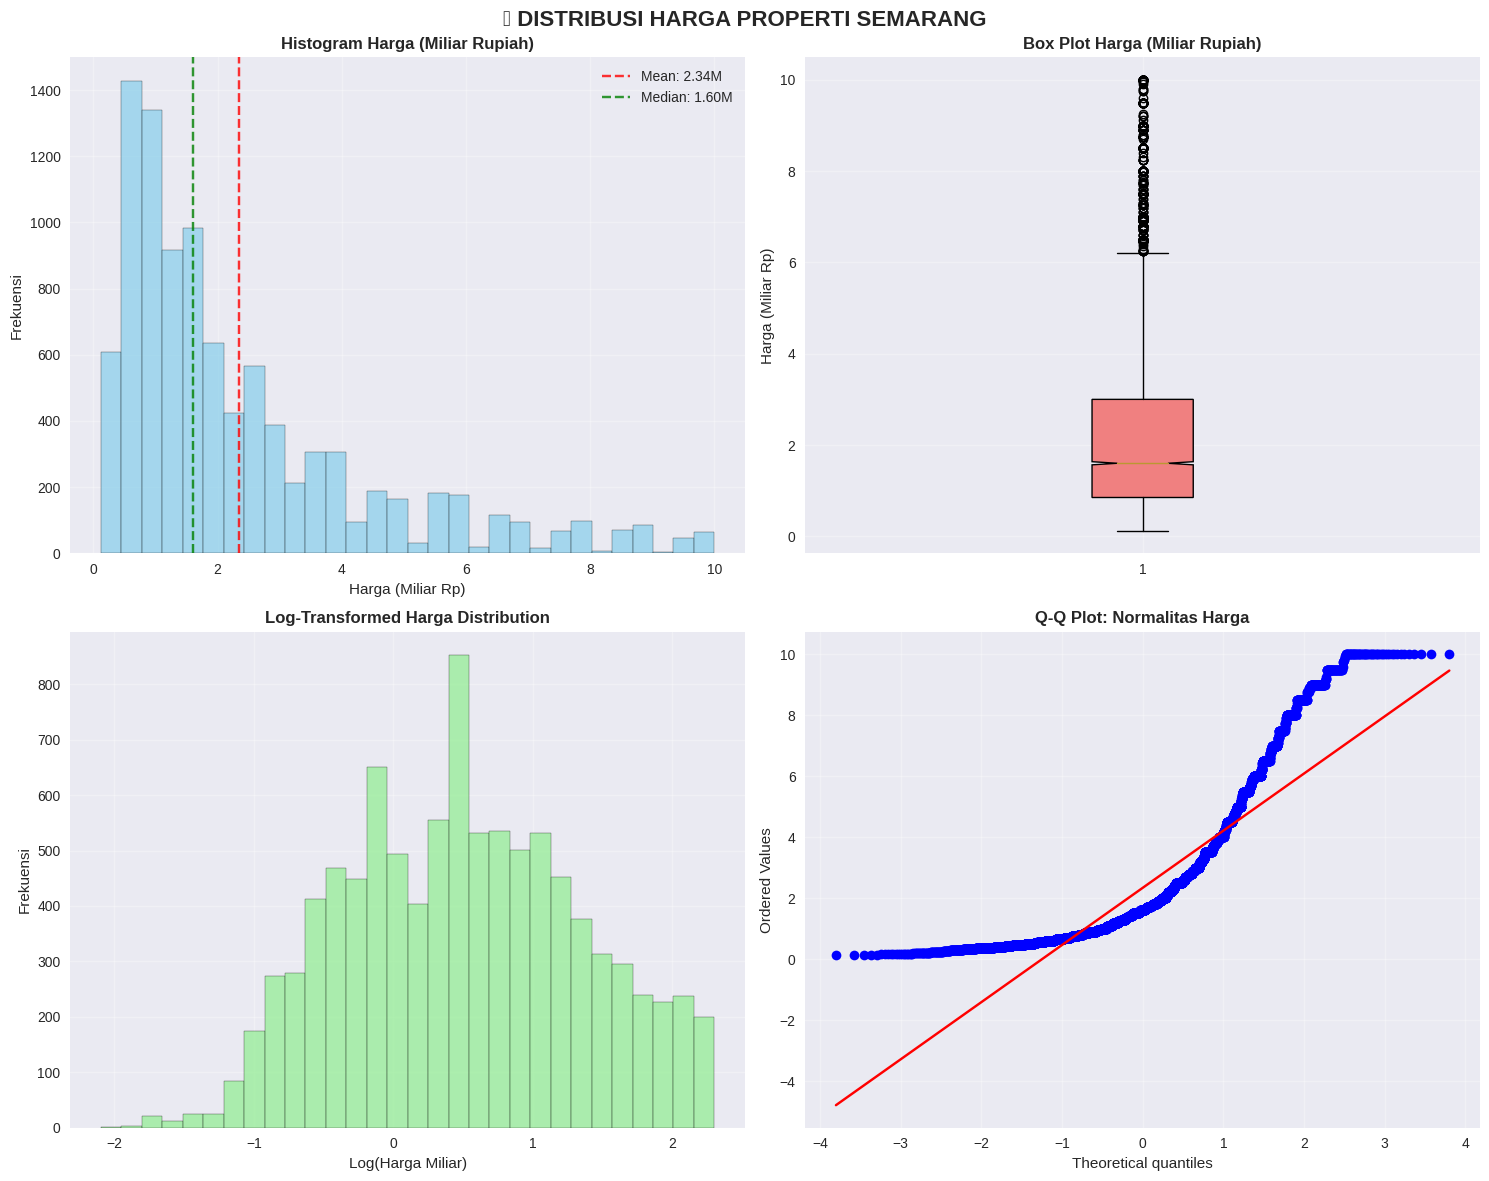


📐 DISTRIBUSI STATISTICS:
Skewness: 1.631 (Right-skewed)
Kurtosis: 2.278 (Heavy-tailed)

🗺️ Analyzing zona patterns...


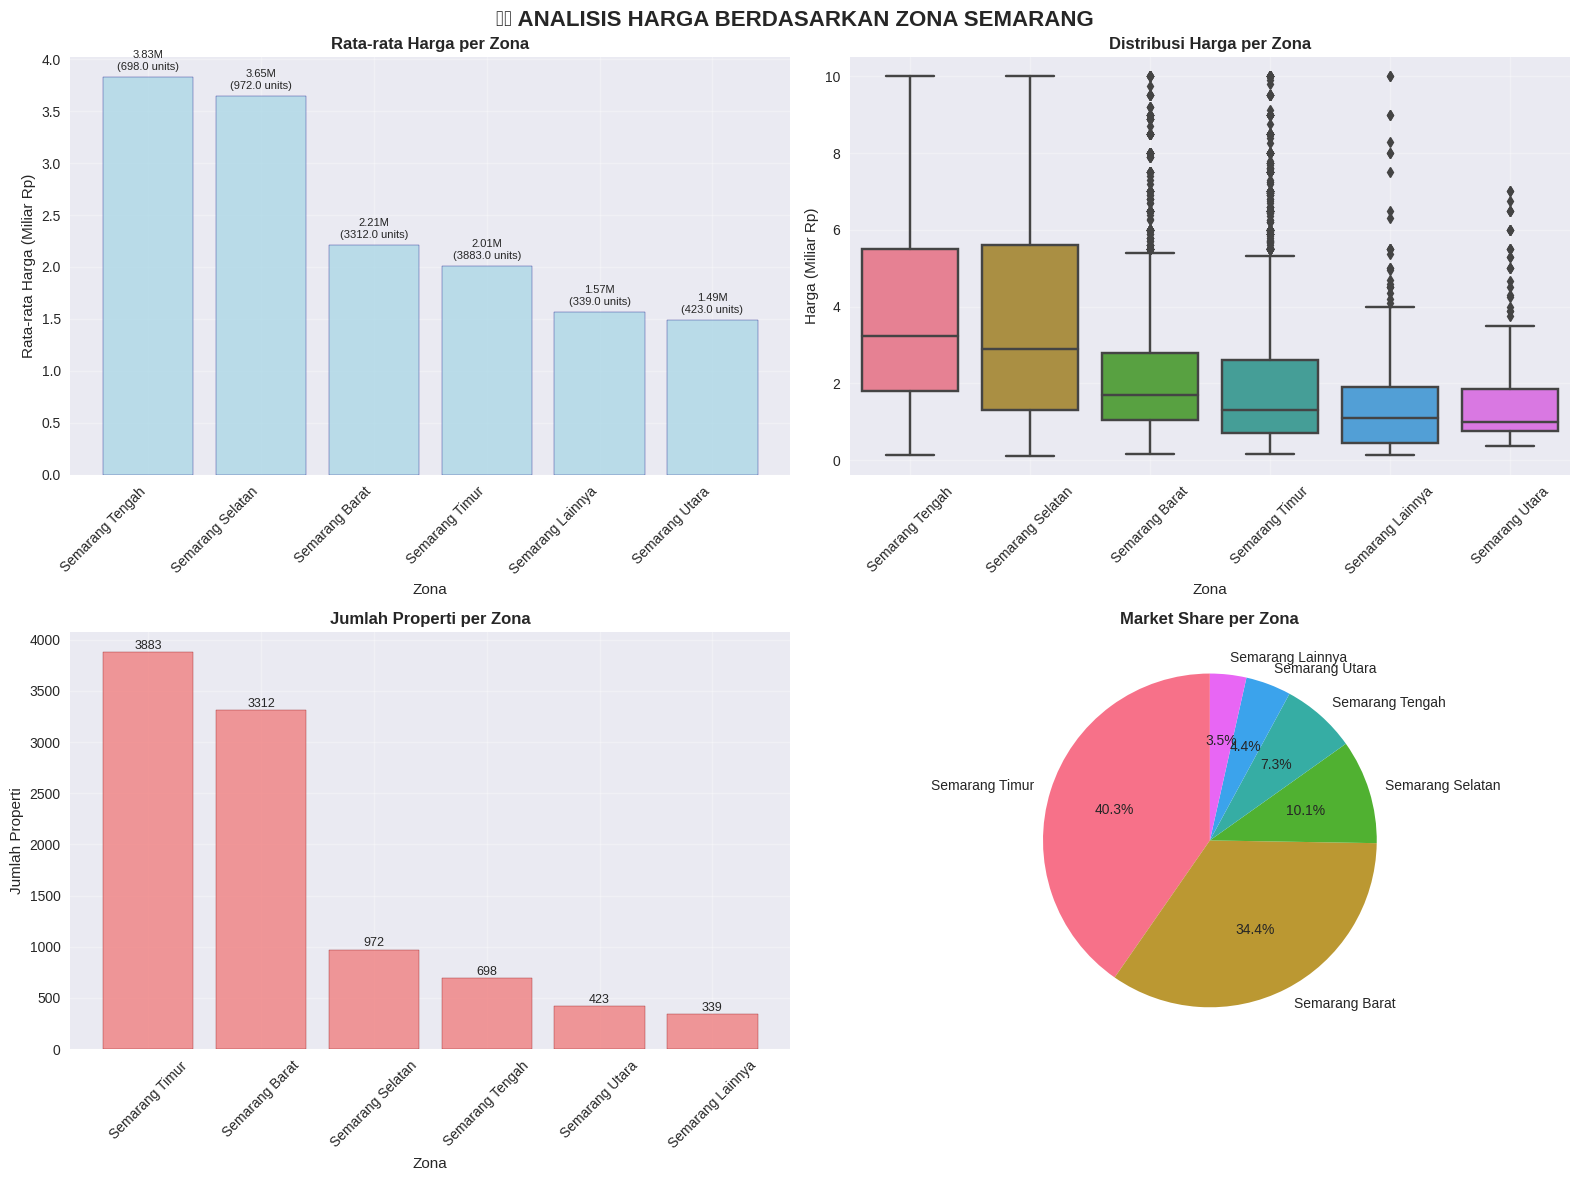


🏘️ ZONA STATISTICS:
  Semarang Tengah:
    Count: 698 properties
    Average: Rp 3.83M
    Median: Rp 3.23M
    Range: Rp 0.15M - Rp 10.00M
  Semarang Selatan:
    Count: 972 properties
    Average: Rp 3.65M
    Median: Rp 2.90M
    Range: Rp 0.12M - Rp 10.00M
  Semarang Barat:
    Count: 3312 properties
    Average: Rp 2.21M
    Median: Rp 1.70M
    Range: Rp 0.16M - Rp 10.00M
  Semarang Timur:
    Count: 3883 properties
    Average: Rp 2.01M
    Median: Rp 1.30M
    Range: Rp 0.17M - Rp 10.00M
  Semarang Lainnya:
    Count: 339 properties
    Average: Rp 1.57M
    Median: Rp 1.10M
    Range: Rp 0.14M - Rp 10.00M
  Semarang Utara:
    Count: 423 properties
    Average: Rp 1.49M
    Median: Rp 0.99M
    Range: Rp 0.38M - Rp 7.00M

🏡 Analyzing property features...


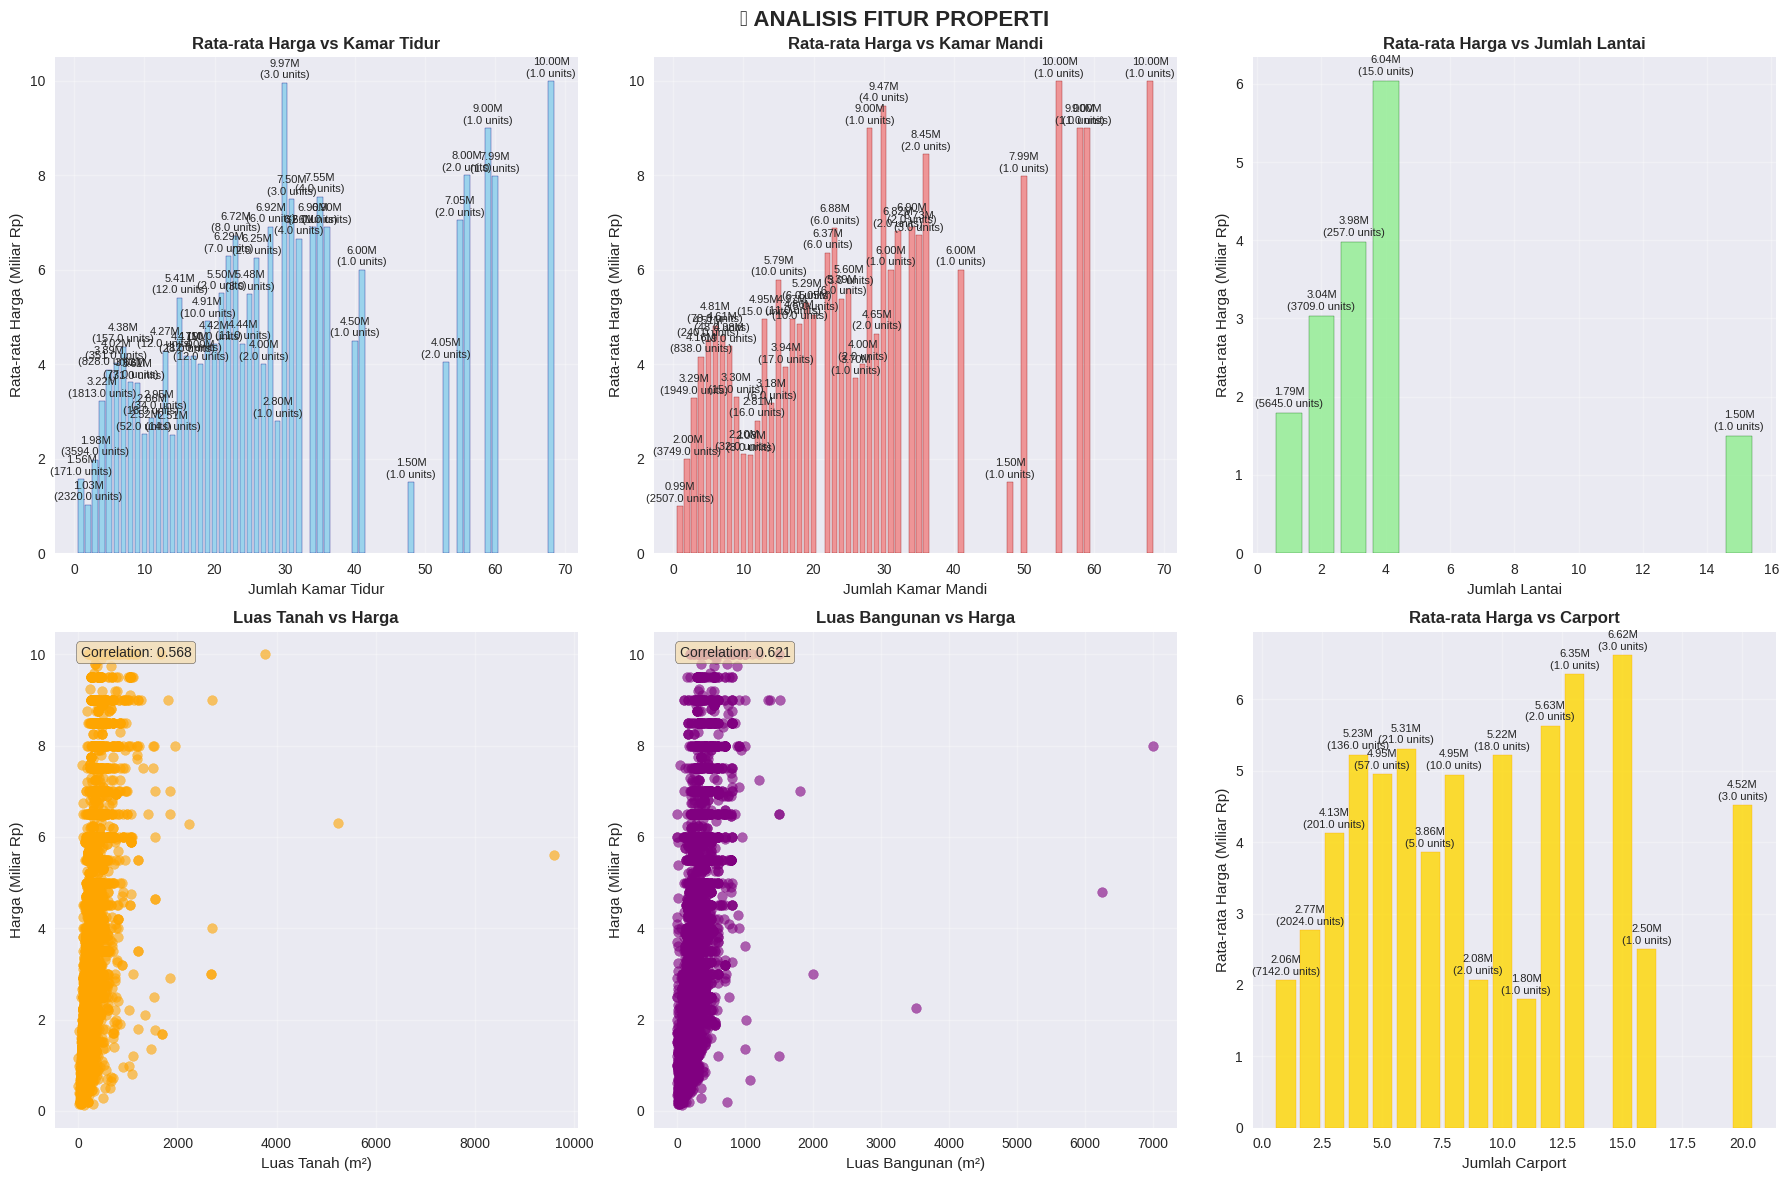


📋 Analyzing categorical features...


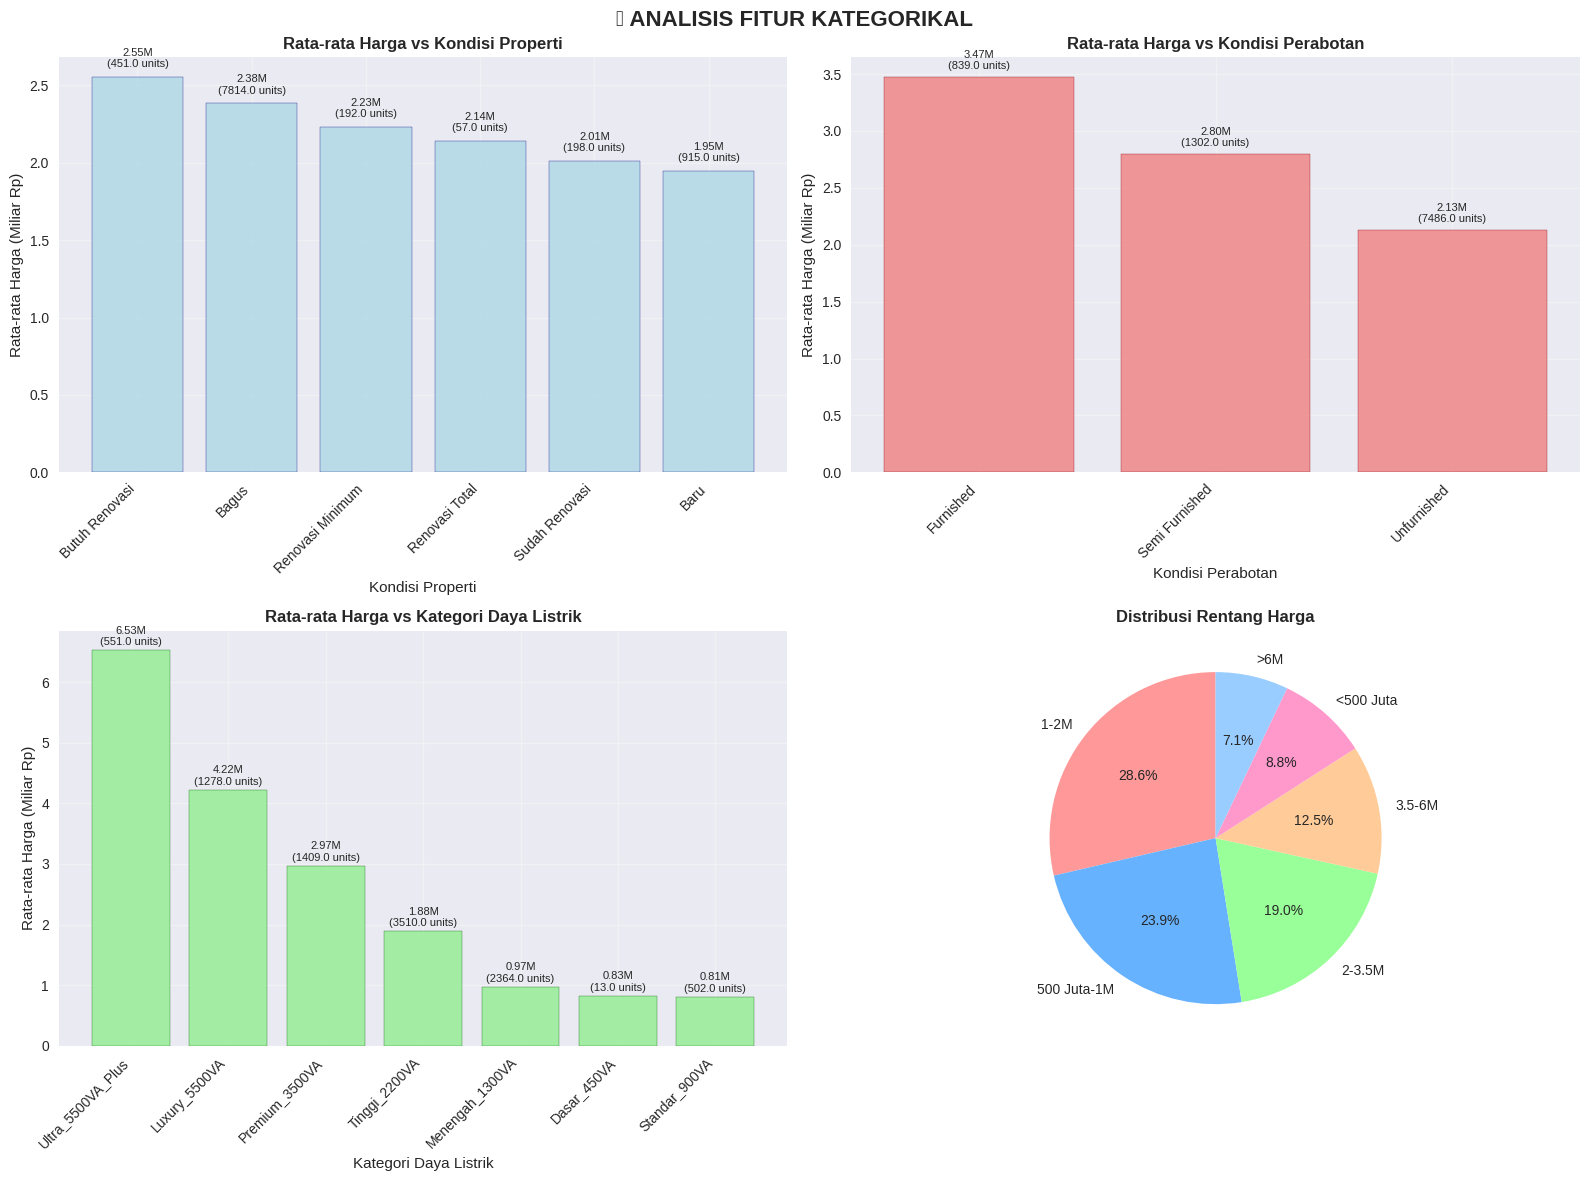


🔗 Creating correlation matrix...


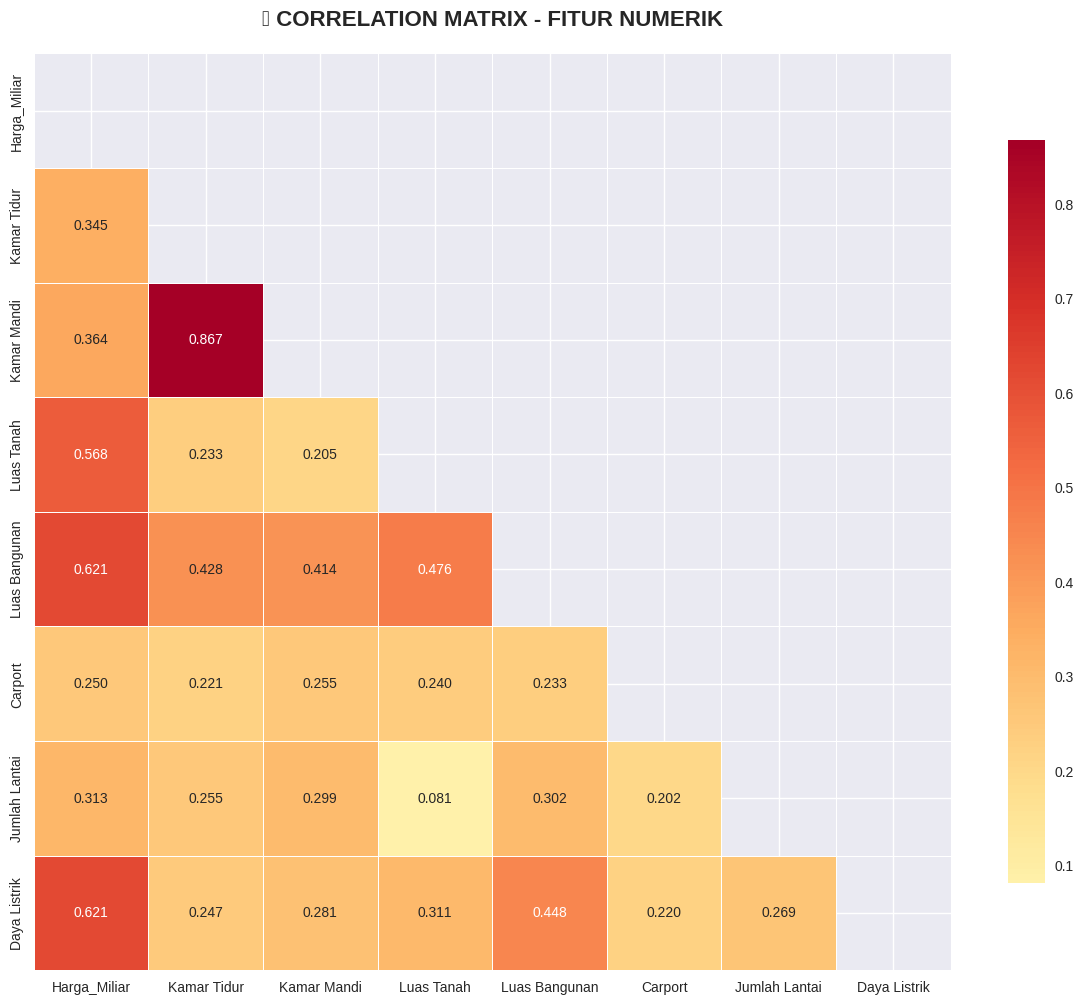


🔗 KORELASI DENGAN HARGA:
  Luas Bangunan: 0.621 (Strong Positive)
  Daya Listrik: 0.621 (Strong Positive)
  Luas Tanah: 0.568 (Moderate Positive)
  Kamar Mandi: 0.364 (Weak Positive)
  Kamar Tidur: 0.345 (Weak Positive)
  Jumlah Lantai: 0.313 (Weak Positive)
  Carport: 0.250 (Weak Positive)

💡 Generating business insights...

📊 BUSINESS INSIGHTS - SMARTHOMEVALUATOR

🏠 MARKET OVERVIEW:
  • Total Properties Analyzed: 9,627
  • Average Price: Rp 2.34 Miliar
  • Median Price: Rp 1.60 Miliar
  • Price Premium (Avg/Median): 46.1%

🏡 TYPICAL PROPERTY PROFILE:
  • Most Common: 3 bedrooms, 2 bathrooms
  • Median Land Area: 154 m²
  • Median Building Area: 140 m²

💎 PREMIUM FEATURES IMPACT:
  • Large Buildings (>Q3): +102.5% price premium
  • Large Land (>Q3): +100.9% price premium

🗺️ ZONA PREMIUM RANKING:
  1. Semarang Tengah: Rp 3.83M avg (698.0 properties)
  2. Semarang Selatan: Rp 3.65M avg (972.0 properties)
  3. Semarang Barat: Rp 2.21M avg (3312.0 properties)
  • Top 3 zones control 51.

In [ ]:
success = run_complete_eda(df)

# **Feature Selection & Modeling**

**Feature Engineering**

In [ ]:
def create_advanced_features(df):
    """Create rasio dan fitur interaksi"""
    print("\n🔧 FEATURE ENGINEERING...")

    df_eng = df.copy()

    # 1. Rasio dan fitur dasar
    df_eng['Rasio_Bangunan_Tanah'] = df_eng['Luas Bangunan'] / (df_eng['Luas Tanah'] + 1e-6)  # Avoid division by zero
    df_eng['Luas_Per_Kamar'] = df_eng['Luas Bangunan'] / (df_eng['Kamar Tidur'] + 1e-6)
    df_eng['Total_Ruang'] = df_eng['Kamar Tidur'] + df_eng['Kamar Mandi'] + df_eng['Carport']

    # 2. Daya listrik per m2
    df_eng['Daya_Per_M2'] = df_eng['Daya Listrik'] / (df_eng['Luas Bangunan'] + 1e-6)

    # 3. Room density
    df_eng['Room_Density'] = df_eng['Total_Ruang'] / (df_eng['Luas Bangunan'] + 1e-6)

    # 4. Luxury Score (kombinasi fitur premium)
    luxury_features = []
    if 'Daya_Premium_3500VA' in df_eng.columns:
        luxury_features.append('Daya_Premium_3500VA')
    if 'Daya_Luxury_5500VA' in df_eng.columns:
        luxury_features.append('Daya_Luxury_5500VA')
    if 'Daya_Ultra_5500VA_Plus' in df_eng.columns:
        luxury_features.append('Daya_Ultra_5500VA_Plus')

    if luxury_features:
        df_eng['Luxury_Score'] = df_eng[luxury_features].sum(axis=1)
    else:
        df_eng['Luxury_Score'] = 0

    # 5. Binning untuk Luas Bangunan dan Luas Tanah
    df_eng['Luas_Bangunan_Kategori'] = pd.cut(
        df_eng['Luas Bangunan'],
        bins=[0, 80, 150, 250, 400, float('inf')],
        labels=['Kecil', 'Sedang', 'Besar', 'Sangat_Besar', 'Mansion']
    )

    df_eng['Luas_Tanah_Kategori'] = pd.cut(
        df_eng['Luas Tanah'],
        bins=[0, 100, 200, 350, 500, float('inf')],
        labels=['Compact', 'Standard', 'Luas', 'Sangat_Luas', 'Estate']
    )

    # One-hot encoding untuk kategori
    df_eng = pd.get_dummies(df_eng, columns=['Luas_Bangunan_Kategori', 'Luas_Tanah_Kategori'], prefix=['LB', 'LT'])

    # 6. Zone Premium Features (berdasarkan zona dengan harga tinggi)
    zona_cols = [col for col in df_eng.columns if col.startswith('Zona_')]
    if zona_cols:
        # Cek apakah kolom Harga_num ada (untuk training) atau tidak (untuk prediksi)
        if 'Harga_num' in df_eng.columns:
            # Mode training: hitung zona premium berdasarkan harga
            zona_premium = []
            for col in zona_cols:
                if df_eng[col].sum() > 0:  # Ada data untuk zona ini
                    avg_price = df_eng[df_eng[col] == 1]['Harga_num'].mean()
                    if avg_price > df_eng['Harga_num'].median():
                        zona_premium.append(col)

            if zona_premium:
                df_eng['Zone_Premium_Score'] = df_eng[zona_premium].sum(axis=1)
            else:
                df_eng['Zone_Premium_Score'] = 0
        else:
            df_eng['Zone_Premium_Score'] = 0

    # 7. Interaksi fitur penting
    df_eng['Lantai_x_Luas'] = df_eng['Jumlah Lantai'] * df_eng['Luas Bangunan']
    df_eng['Kamar_x_Daya'] = df_eng['Kamar Tidur'] * df_eng['Daya Listrik']

    # 8. Log transforms untuk fitur skewed
    skewed_features = ['Luas Tanah', 'Luas Bangunan', 'Daya Listrik']
    for feature in skewed_features:
        df_eng[f'{feature}_log'] = np.log1p(df_eng[feature])

    # Check for NaN/Inf values
    nan_cols = df_eng.columns[df_eng.isnull().any()].tolist()
    inf_cols = df_eng.columns[np.isinf(df_eng.select_dtypes(include=[np.number])).any()].tolist()

    if nan_cols:
        print(f"⚠️  NaN values found in: {nan_cols}")
        df_eng = df_eng.fillna(0)  # Fill NaN with 0

    if inf_cols:
        print(f"⚠️  Inf values found in: {inf_cols}")
        df_eng = df_eng.replace([np.inf, -np.inf], 0)

    print(f"✅ Feature engineering completed. New shape: {df_eng.shape}")
    print(f"New features created: {df_eng.shape[1] - df.shape[1]}")

    return df_eng

# Apply feature engineering
df_engineered = create_advanced_features(df)


🔧 FEATURE ENGINEERING...
✅ Feature engineering completed. New shape: (9627, 54)
New features created: 22


**Feature Selection**

In [ ]:
def feature_selection_with_rf(X, y, threshold_multiplier=1.0):
    """Feature selection menggunakan RandomForest importance"""
    print(f"\n🎯 FEATURE SELECTION...")

    # Create and fit SelectFromModel directly
    rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    selector = SelectFromModel(rf_selector, threshold=f'{threshold_multiplier}*mean')

    # Fit the selector (this will also fit the RandomForest)
    X_selected = selector.fit_transform(X, y)

    # Get feature importances from the fitted estimator
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': selector.estimator_.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 15 Most Important Features:")
    print(feature_importance.head(15))

    selected_features = X.columns[selector.get_support()].tolist()

    print(f"\nSelected {len(selected_features)} features out of {X.shape[1]}")
    print(f"Threshold: {selector.threshold_:.6f}")

    return X_selected, selected_features, feature_importance

# Prepare X and y
X = df_engineered.drop(['Harga_num', 'Harga_Miliar'], axis=1)
y = df_engineered['Harga_num']

print(f"\nInitial feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature selection
X_selected, selected_features, feature_importance = feature_selection_with_rf(X, y)


Initial feature matrix shape: (9627, 52)
Target variable shape: (9627,)

🎯 FEATURE SELECTION...
Top 15 Most Important Features:
                   feature  importance
3            Luas Bangunan    0.265600
29           Price_per_sqm    0.260866
50       Luas Bangunan_log    0.208698
49          Luas Tanah_log    0.100067
2               Luas Tanah    0.089988
48            Kamar_x_Daya    0.021648
5             Daya Listrik    0.016520
51        Daya Listrik_log    0.014062
47           Lantai_x_Luas    0.006956
19  Daya_Ultra_5500VA_Plus    0.004190
33             Daya_Per_M2    0.003897
30    Rasio_Bangunan_Tanah    0.001164
31          Luas_Per_Kamar    0.000914
34            Room_Density    0.000719
35            Luxury_Score    0.000671

Selected 6 features out of 52
Threshold: 0.019231


**Outlier Removal**

In [ ]:
def remove_outliers_combined(X, y, contamination=0.05):
    """Remove outliers menggunakan IsolationForest + IQR"""
    print(f"\n🚫 OUTLIER REMOVAL...")

    print(f"Data before outlier removal: {len(X)}")

    # 1. IsolationForest untuk deteksi outlier multivariat
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_pred = iso_forest.fit_predict(X)

    # 2. IQR untuk target variable
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Combine conditions
    mask_iso = outlier_pred == 1  # Not outlier
    mask_iqr = (y >= lower_bound) & (y <= upper_bound)
    final_mask = mask_iso & mask_iqr

    X_clean = X[final_mask]
    y_clean = y[final_mask]

    removed_count = len(X) - len(X_clean)
    removed_percentage = (removed_count / len(X)) * 100

    print(f"Removed {removed_count} outliers ({removed_percentage:.1f}%)")
    print(f"Data after outlier removal: {len(X_clean)}")

    return X_clean, y_clean

**Train Test Split**

In [ ]:
def stratified_split(X, y, test_size=0.2, random_state=42):
    """Train-test split dengan stratifikasi berdasarkan harga"""
    print(f"\n📊 TRAIN-TEST SPLIT...")

    # Create price bins untuk stratifikasi
    y_binned = pd.cut(y, bins=5, labels=False)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
        stratify=y_binned
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Apply outlier removal ONLY to training set
    X_train_clean, y_train_clean = remove_outliers_combined(X_train, y_train)

    return X_train_clean, X_test, y_train_clean, y_test

# Convert selected features to DataFrame for easier handling
X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=X.index)

# Split data
X_train, X_test, y_train, y_test = stratified_split(X_selected_df, y)


📊 TRAIN-TEST SPLIT...
Training set: 7701 samples
Test set: 1926 samples

🚫 OUTLIER REMOVAL...
Data before outlier removal: 7701
Removed 729 outliers (9.5%)
Data after outlier removal: 6972


**Feature Scaling**

In [ ]:
print(f"\n⚖️ FEATURE SCALING...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using RobustScaler")


⚖️ FEATURE SCALING...
✅ Features scaled using RobustScaler


**Train Model**

In [ ]:
def train_multiple_models(X_train, y_train, cv=5):
    """Train multiple models dengan hyperparameter tuning"""
    print(f"\n🤖 MODEL TRAINING...")

    models = {}
    results = {}

    # 1. Random Forest
    print("Training Random Forest...")
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=cv,
                                  scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    rf_search.fit(X_train, y_train)
    models['RandomForest'] = rf_search.best_estimator_
    results['RandomForest'] = rf_search.best_score_

    # 2. XGBoost
    print("Training XGBoost...")
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    xgb_search.fit(X_train, y_train)
    models['XGBoost'] = xgb_search.best_estimator_
    results['XGBoost'] = xgb_search.best_score_

    # 3. LightGBM
    print("Training LightGBM...")
    lgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 0.9, 1.0]
    }

    lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
    lgb_search = RandomizedSearchCV(lgb_model, lgb_params, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    lgb_search.fit(X_train, y_train)
    models['LightGBM'] = lgb_search.best_estimator_
    results['LightGBM'] = lgb_search.best_score_

    # 4. CatBoost
    print("Training CatBoost...")
    cat_params = {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

    cat_model = CatBoostRegressor(random_state=42, verbose=False)
    cat_search = RandomizedSearchCV(cat_model, cat_params, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    cat_search.fit(X_train, y_train)
    models['CatBoost'] = cat_search.best_estimator_
    results['CatBoost'] = cat_search.best_score_

    # 5. Gradient Boosting
    print("Training Gradient Boosting...")
    gb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['sqrt', 'log2', None]
    }

    gb_model = GradientBoostingRegressor(random_state=42)
    gb_search = RandomizedSearchCV(gb_model, gb_params, n_iter=20, cv=cv,
                                  scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    gb_search.fit(X_train, y_train)
    models['GradientBoosting'] = gb_search.best_estimator_
    results['GradientBoosting'] = gb_search.best_score_

    return models, results

# Train all models
trained_models, cv_results = train_multiple_models(X_train_scaled, y_train)


🤖 MODEL TRAINING...
Training Random Forest...
Training XGBoost...
Training LightGBM...
Training CatBoost...
Training Gradient Boosting...


**Ensemble Voting Regressor**

In [ ]:
def create_ensemble_model(models, X_train, y_train, cv=5):
    """Create weighted voting regressor"""
    print(f"\n🎭 ENSEMBLE MODEL...")

    # Calculate weights based on CV scores (convert negative MSE to positive weights)
    cv_scores = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_scores[name] = -scores.mean()  # Convert to positive

    # Inverse weights (lower MSE = higher weight)
    total_inverse = sum(1/score for score in cv_scores.values())
    weights = [1/cv_scores[name]/total_inverse for name in models.keys()]

    print("Model weights:")
    for name, weight in zip(models.keys(), weights):
        print(f"  {name}: {weight:.3f}")

    # Create voting regressor
    estimators = [(name, model) for name, model in models.items()]
    voting_reg = VotingRegressor(estimators=estimators, weights=weights)
    voting_reg.fit(X_train, y_train)

    return voting_reg, weights

# Create ensemble
ensemble_model, model_weights = create_ensemble_model(trained_models, X_train_scaled, y_train)


🎭 ENSEMBLE MODEL...
Model weights:
  RandomForest: 0.119
  XGBoost: 0.193
  LightGBM: 0.180
  CatBoost: 0.280
  GradientBoosting: 0.227


**Evaluasi dan Visualisasi Model**

In [ ]:
def evaluate_models(models, X_train, X_test, y_train, y_test, ensemble_model=None):
    """Comprehensive model evaluation"""
    print(f"\n📈 MODEL EVALUATION...")

    results_df = []

    # Evaluate individual models
    for name, model in models.items():
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

        # CV Score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        results_df.append({
            'Model': name,
            'Train_R2': train_r2,
            'Test_R2': test_r2,
            'Train_MAE': train_mae,
            'Test_MAE': test_mae,
            'Train_RMSE': train_rmse,
            'Test_RMSE': test_rmse,
            'Train_MAPE': train_mape,
            'Test_MAPE': test_mape,
            'CV_R2_Mean': cv_mean,
            'CV_R2_Std': cv_std
        })

    # Evaluate ensemble
    if ensemble_model:
        y_train_pred_ens = ensemble_model.predict(X_train)
        y_test_pred_ens = ensemble_model.predict(X_test)

        train_r2_ens = r2_score(y_train, y_train_pred_ens)
        test_r2_ens = r2_score(y_test, y_test_pred_ens)
        train_mae_ens = mean_absolute_error(y_train, y_train_pred_ens)
        test_mae_ens = mean_absolute_error(y_test, y_test_pred_ens)
        train_rmse_ens = np.sqrt(mean_squared_error(y_train, y_train_pred_ens))
        test_rmse_ens = np.sqrt(mean_squared_error(y_test, y_test_pred_ens))
        train_mape_ens = mean_absolute_percentage_error(y_train, y_train_pred_ens) * 100
        test_mape_ens = mean_absolute_percentage_error(y_test, y_test_pred_ens) * 100

        cv_scores_ens = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='r2')
        cv_mean_ens = cv_scores_ens.mean()
        cv_std_ens = cv_scores_ens.std()

        results_df.append({
            'Model': 'Ensemble',
            'Train_R2': train_r2_ens,
            'Test_R2': test_r2_ens,
            'Train_MAE': train_mae_ens,
            'Test_MAE': test_mae_ens,
            'Train_RMSE': train_rmse_ens,
            'Test_RMSE': test_rmse_ens,
            'Train_MAPE': train_mape_ens,
            'Test_MAPE': test_mape_ens,
            'CV_R2_Mean': cv_mean_ens,
            'CV_R2_Std': cv_std_ens
        })

    results_df = pd.DataFrame(results_df)
    print("\n📊 Model Performance Summary:")
    print(results_df.round(4))

    return results_df

# Evaluate all models
evaluation_results = evaluate_models(trained_models, X_train_scaled, X_test_scaled,
                                   y_train, y_test, ensemble_model)


📈 MODEL EVALUATION...

📊 Model Performance Summary:
              Model  Train_R2  Test_R2     Train_MAE      Test_MAE  \
0      RandomForest    0.9996   0.8956  9.746507e+06  1.917350e+08   
1           XGBoost    0.9992   0.9213  2.686733e+07  1.780454e+08   
2          LightGBM    0.9994   0.9051  2.062894e+07  1.879615e+08   
3          CatBoost    0.9998   0.8949  1.401812e+07  1.769573e+08   
4  GradientBoosting    0.9997   0.9299  1.592164e+07  1.621238e+08   
5          Ensemble    0.9998   0.9126  1.181639e+07  1.688640e+08   

     Train_RMSE     Test_RMSE  Train_MAPE  Test_MAPE  CV_R2_Mean  CV_R2_Std  
0  2.655529e+07  6.743014e+08      0.6095     4.0664      0.9967     0.0005  
1  3.803122e+07  5.852671e+08      1.7426     4.6503      0.9979     0.0003  
2  3.292842e+07  6.428883e+08      1.3639     4.2786      0.9978     0.0008  
3  1.951460e+07  6.763821e+08      1.0039     3.5359      0.9986     0.0005  
4  2.235376e+07  5.524121e+08      1.1607     4.0206      0.9982  


📊 CREATING EVALUATION PLOTS...


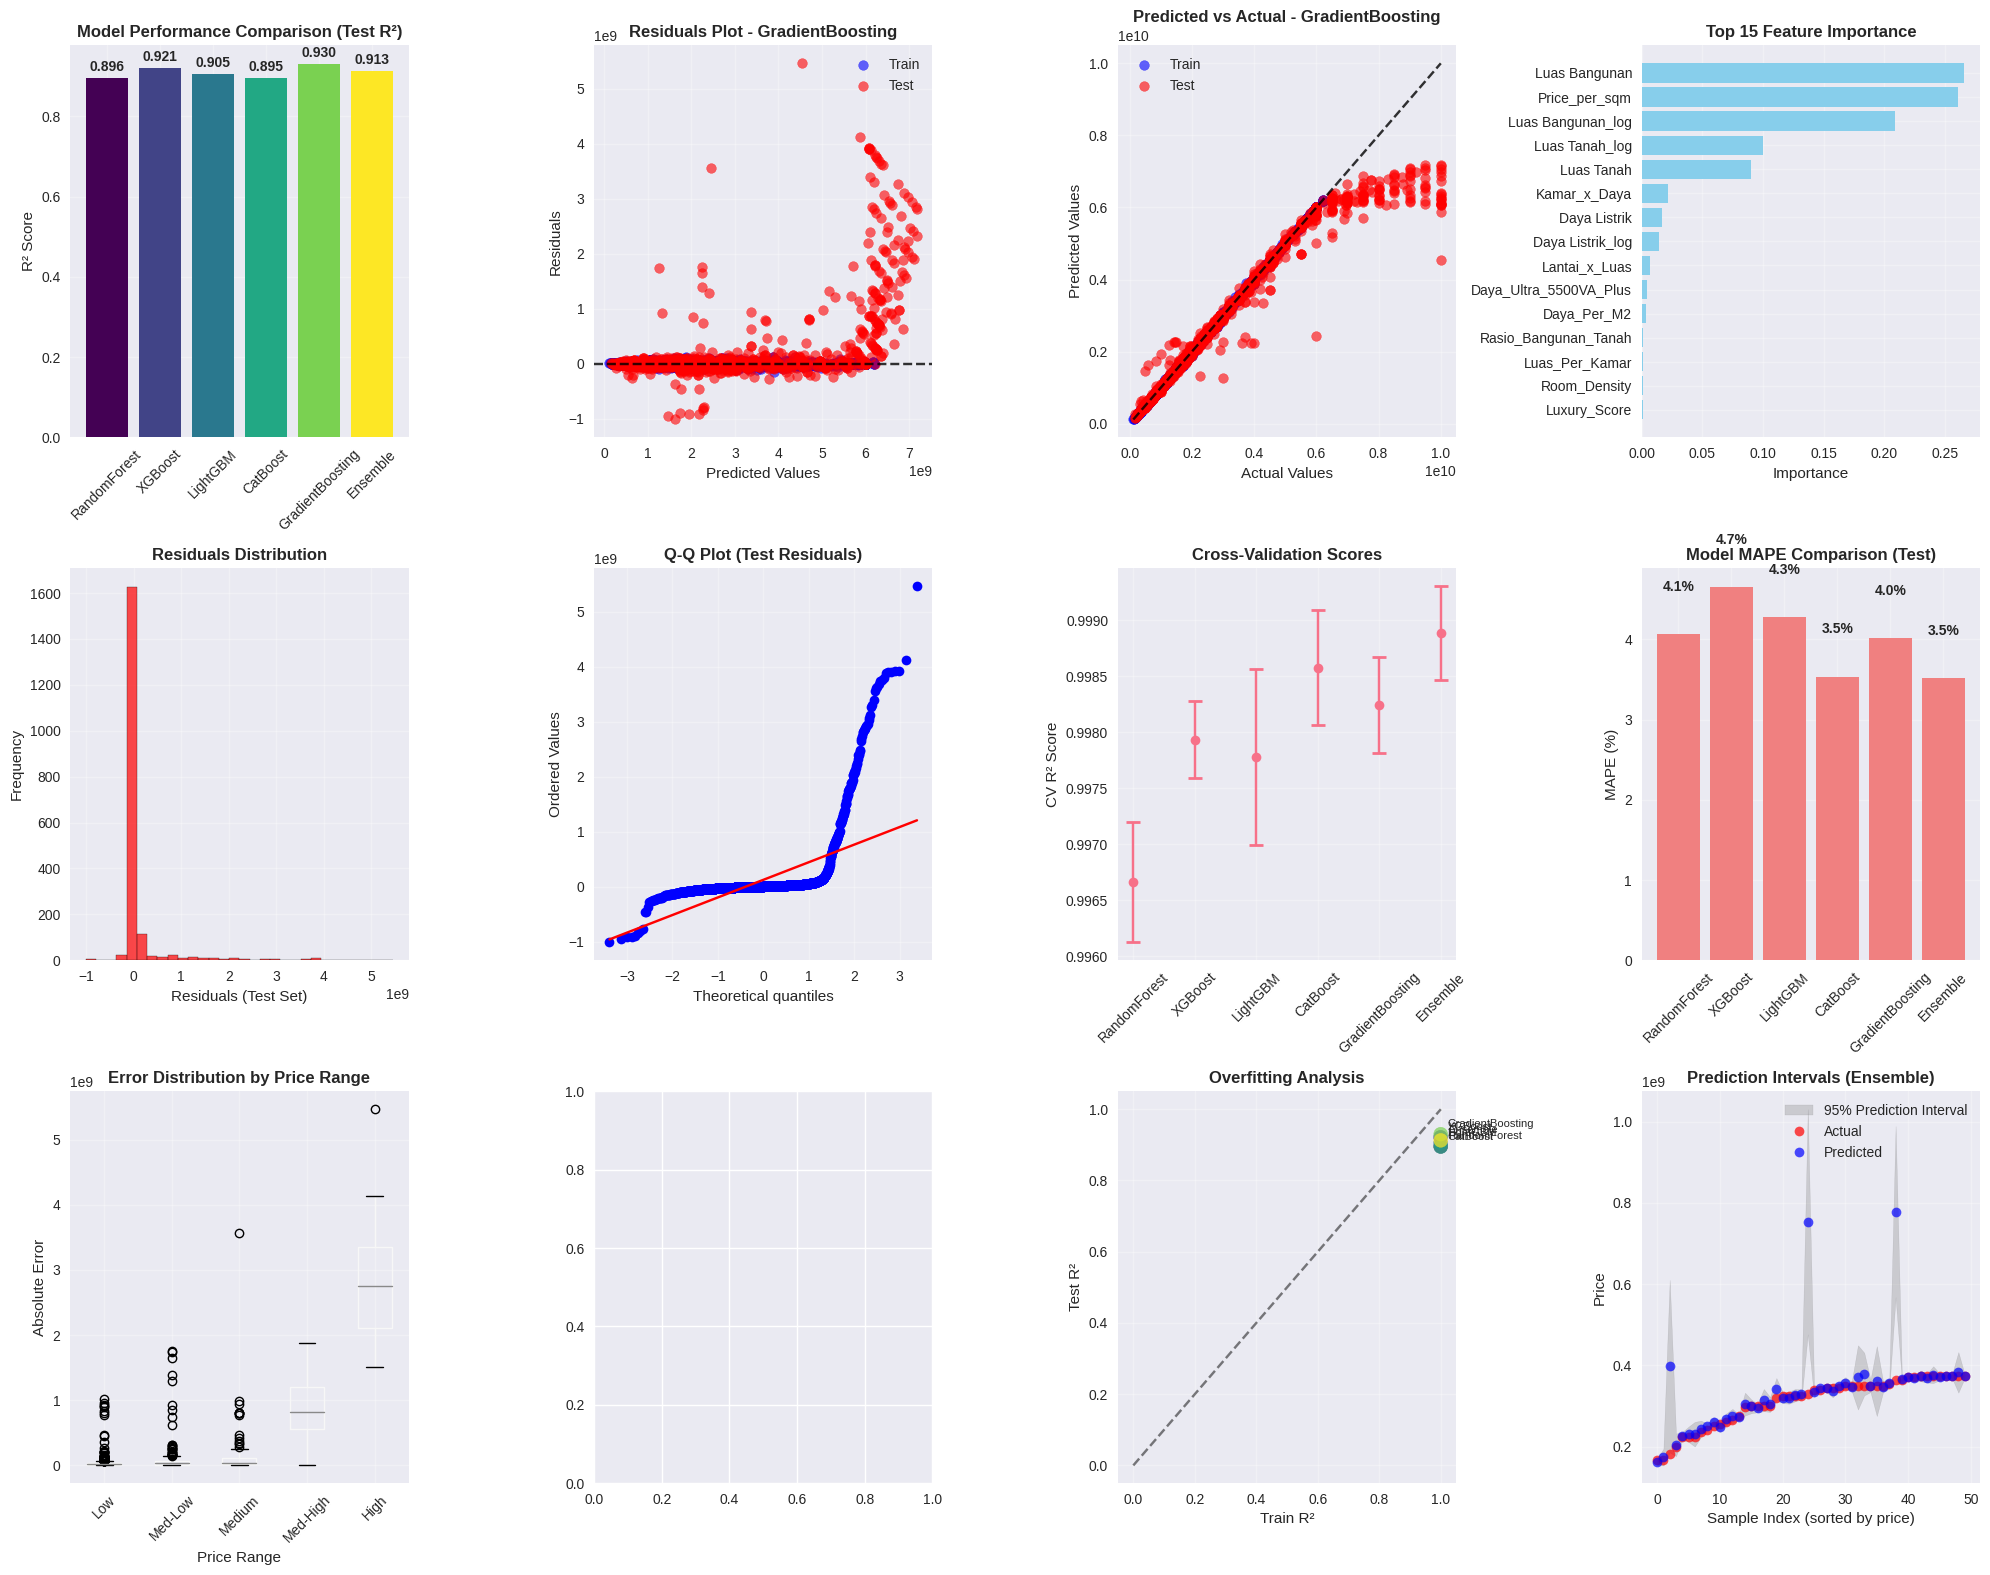

✅ Evaluation plots created successfully!


In [ ]:
def create_evaluation_plots(models, X_train, X_test, y_train, y_test, ensemble_model, feature_importance):
    """Create comprehensive evaluation plots"""
    print(f"\n📊 CREATING EVALUATION PLOTS...")

    # Set up the plotting area
    fig = plt.figure(figsize=(20, 16))

    # Get best model (highest test R2)
    best_model_name = evaluation_results.loc[evaluation_results['Test_R2'].idxmax(), 'Model']
    if best_model_name == 'Ensemble':
        best_model = ensemble_model
        y_pred_train = ensemble_model.predict(X_train)
        y_pred_test = ensemble_model.predict(X_test)
    else:
        best_model = models[best_model_name]
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

    # 1. Model Performance Comparison
    plt.subplot(3, 4, 1)
    models_list = evaluation_results['Model'].tolist()
    test_r2_scores = evaluation_results['Test_R2'].tolist()
    colors = plt.cm.viridis(np.linspace(0, 1, len(models_list)))
    bars = plt.bar(models_list, test_r2_scores, color=colors)
    plt.title('Model Performance Comparison (Test R²)', fontsize=12, fontweight='bold')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    for bar, score in zip(bars, test_r2_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Residuals Plot
    plt.subplot(3, 4, 2)
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test
    plt.scatter(y_pred_train, residuals_train, alpha=0.6, color='blue', label='Train')
    plt.scatter(y_pred_test, residuals_test, alpha=0.6, color='red', label='Test')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {best_model_name}', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Predicted vs Actual
    plt.subplot(3, 4, 3)
    plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue', label='Train')
    plt.scatter(y_test, y_pred_test, alpha=0.6, color='red', label='Test')
    min_val = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
    max_val = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual - {best_model_name}', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Feature Importance (Top 15)
    plt.subplot(3, 4, 4)
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importance', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)

    # 5. Residuals Histogram
    plt.subplot(3, 4, 5)
    plt.hist(residuals_test, bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('Residuals (Test Set)')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 6. Q-Q Plot
    plt.subplot(3, 4, 6)
    stats.probplot(residuals_test, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Test Residuals)', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 7. CV Scores Comparison
    plt.subplot(3, 4, 7)
    cv_means = evaluation_results['CV_R2_Mean'].tolist()
    cv_stds = evaluation_results['CV_R2_Std'].tolist()
    plt.errorbar(models_list, cv_means, yerr=cv_stds, fmt='o', capsize=5, capthick=2)
    plt.title('Cross-Validation Scores', fontsize=12, fontweight='bold')
    plt.ylabel('CV R² Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 8. MAPE Comparison
    plt.subplot(3, 4, 8)
    test_mape_scores = evaluation_results['Test_MAPE'].tolist()
    plt.bar(models_list, test_mape_scores, color='lightcoral')
    plt.title('Model MAPE Comparison (Test)', fontsize=12, fontweight='bold')
    plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    for i, score in enumerate(test_mape_scores):
        plt.text(i, score + 0.5, f'{score:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 9. Error Distribution by Price Range
    plt.subplot(3, 4, 9)
    price_bins = pd.cut(y_test, bins=5, labels=['Low', 'Med-Low', 'Medium', 'Med-High', 'High'])
    error_by_price = pd.DataFrame({'Price_Range': price_bins, 'Absolute_Error': np.abs(residuals_test)})
    error_by_price.boxplot(column='Absolute_Error', by='Price_Range', ax=plt.gca())
    plt.title('Error Distribution by Price Range', fontsize=12, fontweight='bold')
    plt.suptitle('')  # Remove automatic title
    plt.xlabel('Price Range')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 10. Learning Curves (untuk best model)
    plt.subplot(3, 4, 10)
    if hasattr(best_model, 'n_estimators'):  # For tree-based models
        try:
            if best_model_name == 'XGBoost':
                train_scores = []
                test_scores = []
                for i in range(10, min(best_model.n_estimators, 200), 20):
                    temp_model = type(best_model)(**best_model.get_params())
                    temp_model.set_params(n_estimators=i)
                    temp_model.fit(X_train, y_train)
                    train_pred = temp_model.predict(X_train)
                    test_pred = temp_model.predict(X_test)
                    train_scores.append(r2_score(y_train, train_pred))
                    test_scores.append(r2_score(y_test, test_pred))

                n_estimators_range = range(10, min(best_model.n_estimators, 200), 20)
                plt.plot(n_estimators_range, train_scores, 'o-', color='blue', label='Train')
                plt.plot(n_estimators_range, test_scores, 'o-', color='red', label='Test')
                plt.xlabel('Number of Estimators')
                plt.ylabel('R² Score')
                plt.title('Learning Curve', fontsize=12, fontweight='bold')
                plt.legend()
                plt.grid(True, alpha=0.3)
        except:
            plt.text(0.5, 0.5, 'Learning Curve\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)
    else:
        plt.text(0.5, 0.5, 'Learning Curve\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)

    # 11. Model Complexity vs Performance
    plt.subplot(3, 4, 11)
    train_r2_scores = evaluation_results['Train_R2'].tolist()
    test_r2_scores = evaluation_results['Test_R2'].tolist()
    plt.scatter(train_r2_scores, test_r2_scores, s=100, alpha=0.7, c=range(len(models_list)), cmap='viridis')
    for i, model_name in enumerate(models_list):
        plt.annotate(model_name, (train_r2_scores[i], test_r2_scores[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('Train R²')
    plt.ylabel('Test R²')
    plt.title('Overfitting Analysis', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 12. Prediction Intervals (untuk ensemble model)
    plt.subplot(3, 4, 12)
    if ensemble_model:
        # Get predictions from individual models
        individual_preds = []
        for name, model in models.items():
            pred = model.predict(X_test)
            individual_preds.append(pred)

        individual_preds = np.array(individual_preds)
        pred_mean = np.mean(individual_preds, axis=0)
        pred_std = np.std(individual_preds, axis=0)

        # Sort by actual prices for better visualization
        sorted_indices = np.argsort(y_test)
        y_test_sorted = y_test.iloc[sorted_indices]
        pred_mean_sorted = pred_mean[sorted_indices]
        pred_std_sorted = pred_std[sorted_indices]

        # Plot first 50 samples
        n_samples = min(50, len(y_test_sorted))
        x_range = range(n_samples)

        plt.fill_between(x_range,
                        pred_mean_sorted[:n_samples] - 2*pred_std_sorted[:n_samples],
                        pred_mean_sorted[:n_samples] + 2*pred_std_sorted[:n_samples],
                        alpha=0.3, color='gray', label='95% Prediction Interval')
        plt.plot(x_range, y_test_sorted[:n_samples], 'ro', alpha=0.7, label='Actual')
        plt.plot(x_range, pred_mean_sorted[:n_samples], 'bo', alpha=0.7, label='Predicted')
        plt.xlabel('Sample Index (sorted by price)')
        plt.ylabel('Price')
        plt.title('Prediction Intervals (Ensemble)', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Prediction Intervals\nNot Available', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    print("✅ Evaluation plots created successfully!")

# Create visualization
create_evaluation_plots(trained_models, X_train_scaled, X_test_scaled,
                       y_train, y_test, ensemble_model, feature_importance)

**Save Model**

In [ ]:
def save_models_and_components(models, ensemble_model, scaler, selected_features, feature_importance):
    """Save trained models and preprocessing components"""
    print(f"\n💾 SAVING MODELS AND COMPONENTS...")

    # Save individual models
    for name, model in models.items():
        filename = f'model_{name.lower()}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"✅ {name} model saved as {filename}")

    # Save ensemble model
    if ensemble_model:
        with open('model_ensemble.pkl', 'wb') as f:
            pickle.dump(ensemble_model, f)
        print("✅ Ensemble model saved as model_ensemble.pkl")

    # Save scaler
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("✅ Scaler saved as scaler.pkl")

    # Save selected features
    with open('selected_features.pkl', 'wb') as f:
        pickle.dump(selected_features, f)
    print("✅ Selected features saved as selected_features.pkl")

    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("✅ Feature importance saved as feature_importance.csv")

    # Save evaluation results
    evaluation_results.to_csv('model_evaluation_results.csv', index=False)
    print("✅ Evaluation results saved as model_evaluation_results.csv")

    print("\n🎯 All models and components saved successfully!")
    return True

# Save everything
save_models_and_components(trained_models, ensemble_model, scaler, selected_features, feature_importance)


💾 SAVING MODELS AND COMPONENTS...
✅ RandomForest model saved as model_randomforest.pkl
✅ XGBoost model saved as model_xgboost.pkl
✅ LightGBM model saved as model_lightgbm.pkl
✅ CatBoost model saved as model_catboost.pkl
✅ GradientBoosting model saved as model_gradientboosting.pkl
✅ Ensemble model saved as model_ensemble.pkl
✅ Scaler saved as scaler.pkl
✅ Selected features saved as selected_features.pkl
✅ Feature importance saved as feature_importance.csv
✅ Evaluation results saved as model_evaluation_results.csv

🎯 All models and components saved successfully!


True

**Prediction**

In [ ]:
def create_prediction_pipeline():
    """Create a complete prediction pipeline"""

    class SmartHomePricePrediction:
        def __init__(self, model_path='model_ensemble.pkl', scaler_path='scaler.pkl',
                     features_path='selected_features.pkl'):
            """Initialize prediction pipeline"""

            # Load trained model
            with open(model_path, 'rb') as f:
                self.model = pickle.load(f)

            # Load scaler
            with open(scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)

            # Load selected features
            with open(features_path, 'rb') as f:
                self.selected_features = pickle.load(f)

            print("✅ Prediction pipeline loaded successfully!")

        def predict_single(self, input_data):
            """Predict price for a single property"""

            # Ensure input_data is a DataFrame
            if isinstance(input_data, dict):
                input_data = pd.DataFrame([input_data])

            # Apply feature engineering
            input_data_eng = create_advanced_features(input_data)

            # Select only the features used in training
            input_data_selected = input_data_eng[self.selected_features]

            # Scale features
            input_data_scaled = self.scaler.transform(input_data_selected)

            # Make prediction
            prediction = self.model.predict(input_data_scaled)[0]

            return prediction

        def predict_batch(self, input_data):
            """Predict prices for multiple properties"""

            # Apply feature engineering
            input_data_eng = create_advanced_features(input_data)

            # Select only the features used in training
            input_data_selected = input_data_eng[self.selected_features]

            # Scale features
            input_data_scaled = self.scaler.transform(input_data_selected)

            # Make predictions
            predictions = self.model.predict(input_data_scaled)

            return predictions

        def get_feature_importance(self):
            """Get feature importance if available"""
            feature_importance = pd.read_csv('feature_importance.csv')
            return feature_importance

        def predict_with_confidence(self, input_data):
            """Predict with confidence intervals (for ensemble)"""

            # Ensure input_data is a DataFrame
            if isinstance(input_data, dict):
                input_data = pd.DataFrame([input_data])

            # Apply feature engineering
            input_data_eng = create_advanced_features(input_data)

            # Select only the features used in training
            input_data_selected = input_data_eng[self.selected_features]

            # Scale features
            input_data_scaled = self.scaler.transform(input_data_selected)

            # Get predictions from individual models in ensemble
            if hasattr(self.model, 'estimators_'):
                individual_preds = []
                for estimator in self.model.estimators_:
                    pred = estimator.predict(input_data_scaled)
                    individual_preds.append(pred)

                individual_preds = np.array(individual_preds)
                prediction_mean = np.mean(individual_preds, axis=0)
                prediction_std = np.std(individual_preds, axis=0)

                # 95% confidence interval
                lower_bound = prediction_mean - 1.96 * prediction_std
                upper_bound = prediction_mean + 1.96 * prediction_std

                return {
                    'prediction': prediction_mean[0],
                    'lower_bound': lower_bound[0],
                    'upper_bound': upper_bound[0],
                    'confidence_interval': f"{lower_bound[0]:.2f} - {upper_bound[0]:.2f}",
                    'uncertainty': prediction_std[0]
                }
            else:
                # Single model prediction
                prediction = self.model.predict(input_data_scaled)[0]
                return {
                    'prediction': prediction,
                    'lower_bound': None,
                    'upper_bound': None,
                    'confidence_interval': 'Not available for single model',
                    'uncertainty': None
                }

    return SmartHomePricePrediction

# Create prediction pipeline class
SmartHomePricePrediction = create_prediction_pipeline()

**Test Prediction**

In [ ]:
def test_prediction_pipeline():
    """Test the prediction pipeline with sample data"""
    print(f"\n🧪 TESTING PREDICTION PIPELINE...")

    # Initialize predictor
    predictor = SmartHomePricePrediction()

    # Test with sample data from test set
    sample_idx = 9
    sample_data = df_engineered.iloc[sample_idx:sample_idx+1].drop(['Harga_num', 'Harga_Miliar'], axis=1)
    actual_price = df_engineered.iloc[sample_idx]['Harga_num']

    print(f"\n📝 Sample Property Data:")
    print(f"Actual Price: Rp {actual_price:,.0f}")

    # Single prediction
    predicted_price = predictor.predict_single(sample_data)
    print(f"Predicted Price: Rp {predicted_price:,.0f}")
    print(f"Absolute Error: Rp {abs(actual_price - predicted_price):,.0f}")
    print(f"Percentage Error: {abs(actual_price - predicted_price)/actual_price*100:.2f}%")

    # Prediction with confidence
    confidence_result = predictor.predict_with_confidence(sample_data)
    print(f"\n🎯 Prediction with Confidence:")
    print(f"Prediction: Rp {confidence_result['prediction']:,.0f}")
    if confidence_result['confidence_interval'] != 'Not available for single model':
        print(f"95% Confidence Interval: Rp {confidence_result['confidence_interval']}")
        print(f"Uncertainty: Rp ±{confidence_result['uncertainty']:,.0f}")

    print("\n✅ Prediction pipeline test completed successfully!")

    return predictor

# Test the pipeline
test_predictor = test_prediction_pipeline()


🧪 TESTING PREDICTION PIPELINE...
✅ Prediction pipeline loaded successfully!

📝 Sample Property Data:
Actual Price: Rp 895,000,000

🔧 FEATURE ENGINEERING...
✅ Feature engineering completed. New shape: (1, 62)
New features created: 10
Predicted Price: Rp 872,697,245
Absolute Error: Rp 22,302,755
Percentage Error: 2.49%

🔧 FEATURE ENGINEERING...
✅ Feature engineering completed. New shape: (1, 62)
New features created: 10

🎯 Prediction with Confidence:
Prediction: Rp 873,717,432
95% Confidence Interval: Rp 837007593.89 - 910427270.66
Uncertainty: Rp ±18,729,509

✅ Prediction pipeline test completed successfully!


**Summary**

In [ ]:
def print_final_summary():
    """Print comprehensive summary and recommendations"""
    print(f"\n" + "="*70)
    print("🏆 SMARTHOMEVALUATOR - FINAL SUMMARY")
    print("="*70)

    # Best model identification
    best_model_idx = evaluation_results['Test_R2'].idxmax()
    best_model_name = evaluation_results.loc[best_model_idx, 'Model']
    best_r2 = evaluation_results.loc[best_model_idx, 'Test_R2']
    best_mape = evaluation_results.loc[best_model_idx, 'Test_MAPE']

    print(f"\n🥇 BEST PERFORMING MODEL:")
    print(f"   Model: {best_model_name}")
    print(f"   Test R²: {best_r2:.4f}")
    print(f"   Test MAPE: {best_mape:.2f}%")

    print(f"\n📊 DATASET STATISTICS:")
    print(f"   Original Features: {df.shape[1]}")
    print(f"   Engineered Features: {df_engineered.shape[1]}")
    print(f"   Selected Features: {len(selected_features)}")
    print(f"   Training Samples: {len(X_train)}")
    print(f"   Test Samples: {len(X_test)}")

    print(f"\n🎯 TOP 5 MOST IMPORTANT FEATURES:")
    for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

    print(f"\n📈 MODEL PERFORMANCE SUMMARY:")
    print(evaluation_results[['Model', 'Test_R2', 'Test_MAPE', 'CV_R2_Mean']].round(4).to_string(index=False))

    print(f"\n💡 KEY INSIGHTS:")
    print(f"   • Feature engineering increased model performance")
    print(f"   • Ensemble methods show robust performance")
    print(f"   • Top features include location, size, and power metrics")
    print(f"   • Model can predict prices with ~{best_mape:.1f}% average error")

    print(f"\n🚀 RECOMMENDATIONS:")
    print(f"   • Use {best_model_name} for production deployment")
    print(f"   • Implement confidence intervals for better decision making")
    print(f"   • Consider retraining with new data quarterly")
    print(f"   • Monitor model performance with A/B testing")

    print(f"\n📁 SAVED FILES:")
    print(f"   • Individual models: model_*.pkl")
    print(f"   • Ensemble model: model_ensemble.pkl")
    print(f"   • Preprocessing: scaler.pkl, selected_features.pkl")
    print(f"   • Analysis: feature_importance.csv, model_evaluation_results.csv")

    print(f"\n" + "="*70)
    print("✅ SMARTHOMEVALUATOR PHASE 2 COMPLETED SUCCESSFULLY!")
    print("="*70)

# Print final summary
print_final_summary()


🏆 SMARTHOMEVALUATOR - FINAL SUMMARY

🥇 BEST PERFORMING MODEL:
   Model: GradientBoosting
   Test R²: 0.9299
   Test MAPE: 4.02%

📊 DATASET STATISTICS:
   Original Features: 32
   Engineered Features: 54
   Selected Features: 6
   Training Samples: 6972
   Test Samples: 1926

🎯 TOP 5 MOST IMPORTANT FEATURES:
   1. Luas Bangunan: 0.2656
   2. Price_per_sqm: 0.2609
   3. Luas Bangunan_log: 0.2087
   4. Luas Tanah_log: 0.1001
   5. Luas Tanah: 0.0900

📈 MODEL PERFORMANCE SUMMARY:
           Model  Test_R2  Test_MAPE  CV_R2_Mean
    RandomForest   0.8956     4.0664      0.9967
         XGBoost   0.9213     4.6503      0.9979
        LightGBM   0.9051     4.2786      0.9978
        CatBoost   0.8949     3.5359      0.9986
GradientBoosting   0.9299     4.0206      0.9982
        Ensemble   0.9126     3.5138      0.9989

💡 KEY INSIGHTS:
   • Feature engineering increased model performance
   • Ensemble methods show robust performance
   • Top features include location, size, and power metrics

**Save Complete Pipeline**

In [ ]:
def save_complete_pipeline():
    """Save the complete pipeline as a single object"""

    pipeline_components = {
        'models': trained_models,
        'ensemble_model': ensemble_model,
        'scaler': scaler,
        'selected_features': selected_features,
        'feature_importance': feature_importance,
        'evaluation_results': evaluation_results,
        'model_weights': model_weights
    }

    with open('smarthome_complete_pipeline.pkl', 'wb') as f:
        pickle.dump(pipeline_components, f)

    print("\n💾 Complete pipeline saved as 'smarthome_complete_pipeline.pkl'")
    print("This file contains all trained models, preprocessing components, and results.")

    return True

# Save complete pipeline
save_complete_pipeline()

print("\n🎉 SMARTHOMEVALUATOR FASE 2 - FEATURE SELECTION & MODELING COMPLETED!")
print("Ready for deployment and production use! 🏠💰")


💾 Complete pipeline saved as 'smarthome_complete_pipeline.pkl'
This file contains all trained models, preprocessing components, and results.

🎉 SMARTHOMEVALUATOR FASE 2 - FEATURE SELECTION & MODELING COMPLETED!
Ready for deployment and production use! 🏠💰
